# Data Analysis of Siemens Web shop Revenues

## Task

You are requested to perform a data analysis and forecasting problem using the dataset provided.

The dataset is sourced from our foreign exchange and commodity risk team's foreign exchange (FX)
portfolio. 

Your task is to conduct an analysis of this data, while also generating insights for the future.



## Preprocess the data

### Apply setting 

In [2]:
# load libraries
import numpy as np
import pandas as pd
import sys, time, os
from datetime import date
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# determine the path to the source folder
pth_to_src = 'C:/DEV/portfolio/src/'

# get date of today:
# Reason: Create outputfolder with current date to store plots and trained model if wanted.
today = '20230622'#date.today().strftime('%Y%m%d')

# input folder:
input_folder = pth_to_src + 'input/'

# output folder:
output_folder = pth_to_src + 'output/' + today + '/' # with date of today. This way a daily history of results can be automatically stored.
output_folder_plots = output_folder+'plots/'  
output_folder_model = output_folder+'model/'

# create output_folder if not existant:
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_folder_plots, exist_ok=True)
os.makedirs(output_folder_model, exist_ok=True)
# load utility functions
sys.path.append(pth_to_src+'/utils/')
from utility import *
# reload functions from utility
from importlib import reload
reload(sys.modules['utility'])

# set random seed for reproducibility
np.random.seed(888) 

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\G\anaconda3\envs\py311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\G\anaconda3\envs\py311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Load, clean, prepare and check the data

In [3]:
# Read the dataframe:
# ignore the empty column Bonuses and the redundant column System.
metrics = ['ChangeRequestCosts', 'AdministrationCosts', 'OverheadCosts', 'Interests', 'Revenue'] 
df = pd.read_excel(pth_to_src+'input/fx_portfolio.xlsx', parse_dates=['Date'], usecols = ['CCY', 'Date'] +metrics ) 
# fill in the values for the merged row cells for column CCY:
df.CCY = pd.Series(df.CCY).fillna(method='ffill')


In [4]:
# add Profit and cumulative profit
df['Profit'] = df[['ChangeRequestCosts', 'AdministrationCosts',
       'OverheadCosts', 'Interests', 'Revenue']].sum(axis=1)

#set date and CCY as index
df = df.set_index([df.Date, df.CCY])

# add _Total_  as sum of the currencies:
df1 = df.groupby(level='Date').sum(numeric_only=True)
df1['CCY'] = '_Total_'
df1['Date'] = df1.index
df1 = df1.set_index([df1.index, df1.CCY])
# append total to df:
df = pd.concat([df, df1])
df = df.set_index([df.Date, df.CCY])

# calculate the cumulative profit:
df['CumulativeProfit']  = df['Profit'].groupby(level='CCY').cumsum()
metrics += ['Profit']

# add the year from :
df['year'] = df.Date.dt.year

# add the fiscal year from 10/10 until 09/30 of the next year:
# Reason: the data seems to be structured in this respective fiscal year.
df['fiscalYear'] = df.Date.dt.to_period('Q-SEP').astype(str).str.extract('(?P<year>\d+)')

df.head(4)

CCY       Date  ChangeRequestCosts  AdministrationCosts  \
Date       CCY                                                            
2019-10-01 EUR  EUR 2019-10-01                 0.0                  0.0   
2019-10-02 EUR  EUR 2019-10-02                 0.0                  0.0   
2019-10-03 EUR  EUR 2019-10-03                 0.0                  0.0   
2019-10-04 EUR  EUR 2019-10-04                 0.0                  0.0   

                OverheadCosts  Interests   Revenue    Profit  \
Date       CCY                                                 
2019-10-01 EUR        -479.45      89.00  16749.79  16359.34   
2019-10-02 EUR        -419.33      80.92  97028.32  96689.91   
2019-10-03 EUR        -446.22     105.12  20628.55  20287.45   
2019-10-04 EUR           0.00     125.52  17327.73  17453.25   

                CumulativeProfit  year fiscalYear  
Date       CCY                                     
2019-10-01 EUR          16359.34  2019       2020  
2019-10-02 EUR         113049.25  2019       2020  
2019-10-03 EUR         133336.70  2019       2020  
2019-10-04 EUR         150789.95  2019       2020

In [5]:
# Show the number of rows and columns of the dataframe:
df.shape

(3920, 11)

In [6]:
# replace the entries with missing values rows with zeros
# Reason: for some day there is no cashflow recorded. So the cash-flows are zero at these days. We may want to keep a data set with full records of daily observations within a week. Doing so can allow us to account for a seasonal trends later on.
print('Number of missing observations with missing data before filling in: %s'%sum(df[metrics].isna().any(axis=1)))
df = df.fillna(0)
print('Number of missing observations with missing data after  filling in: %s'%sum(df[metrics].isna().any(axis=1)))


Number of missing observations with missing data before filling in: 16
Number of missing observations with missing data after  filling in: 0


In [7]:
# Check the number of missing values of each column:
pd.DataFrame([df.isna().sum(),df.isna().mean()],index=['Number of missing values', 'Rate of missing values']).T

Number of missing values  Rate of missing values
CCY                                       0.0                     0.0
Date                                      0.0                     0.0
ChangeRequestCosts                        0.0                     0.0
AdministrationCosts                       0.0                     0.0
OverheadCosts                             0.0                     0.0
Interests                                 0.0                     0.0
Revenue                                   0.0                     0.0
Profit                                    0.0                     0.0
CumulativeProfit                          0.0                     0.0
year                                      0.0                     0.0
fiscalYear                                0.0                     0.0

In [8]:
# Show basic summary statistics of the data:
df.describe()

ChangeRequestCosts  AdministrationCosts  OverheadCosts     Interests  \
count         3920.000000          3920.000000    3920.000000   3920.000000   
mean         -1135.364653          -190.959653    -182.248291    793.951352   
std           5880.314972           943.247451     253.829884   3040.191015   
min         -56578.400000         -6098.970000   -1441.100000  -4144.080000   
25%              0.000000             0.000000    -307.087500     -0.520000   
50%              0.000000             0.000000     -41.795000     24.865000   
75%              0.000000             0.000000       0.000000    188.215000   
max              0.000000             0.000000       0.000000  37312.230000   

             Revenue         Profit  CumulativeProfit         year  
count    3920.000000    3920.000000      3.920000e+03  3920.000000  
mean    12622.722505   11908.101260      4.368011e+06  2020.746173  
std     26466.279294   26832.424068      6.568475e+06     0.924896  
min         0.000000  -48500.090000     -5.068346e+04  2019.000000  
25%        63.387500      24.775000      1.804121e+04  2020.000000  
50%       653.900000     766.225000      1.916453e+05  2021.000000  
75%     12296.157500   11242.890000      8.384901e+06  2021.000000  
max    207016.190000  204689.240000      2.333988e+07  2022.000000

In [9]:
# Show frequency table per CCY and year  in the data set:
year_freq =df.copy().drop(columns=['CCY']).groupby(['fiscalYear','CCY']).size() 
year_freq.columns =['Count']
year_freq

fiscalYear  CCY    
2020        CHF        262
            EUR        262
            GBP        262
            USD        262
            _Total_    262
2021        CHF        261
            EUR        261
            GBP        261
            USD        261
            _Total_    261
2022        CHF        261
            EUR        261
            GBP        261
            USD        261
            _Total_    261
dtype: int64

In [10]:
# Show key metrics per year and CCY:
metrics_per_year_CCY = df[['fiscalYear']+metrics].groupby(['fiscalYear','CCY']).sum()
pd.options.display.float_format =  '{:,.0f}'.format
metrics_per_year_CCY

ChangeRequestCosts  AdministrationCosts  OverheadCosts  \
fiscalYear CCY                                                               
2020       CHF                       0               -1,244        -12,550   
           EUR                -655,258              -98,845        -50,849   
           GBP                 -47,964               -1,240        -35,190   
           USD                 -67,365               -6,273        -22,526   
           _Total_            -770,586             -107,602       -121,116   
2021       CHF                       0               -2,687        -12,114   
           EUR                -571,753             -119,527        -56,331   
           GBP                 -87,968                 -266        -26,452   
           USD                 -68,339               -9,892        -25,787   
           _Total_            -728,060             -132,373       -120,685   
2022       CHF                       0               -4,203        -11,524   
           EUR                -590,816             -124,571        -55,926   
           GBP                 -80,285               -1,461        -26,429   
           USD                 -55,568               -4,070        -21,527   
           _Total_            -726,669             -134,306       -115,406   

                    Interests   Revenue    Profit  
fiscalYear CCY                                     
2020       CHF        -23,222     4,208   -32,807  
           EUR          4,809 8,128,631 7,328,488  
           GBP         14,030    95,643    25,279  
           USD         35,630   174,483   113,948  
           _Total_     31,247 8,402,966 7,434,908  
2021       CHF          1,131     4,233    -9,437  
           EUR           -915 7,449,204 6,700,678  
           GBP         67,795    96,664    49,772  
           USD          7,342   167,046    70,369  
           _Total_     75,353 7,717,146 6,811,382  
2022       CHF          2,916     4,372    -8,439  
           EUR          1,602 8,337,958 7,568,247  
           GBP      1,432,479   106,787 1,431,091  
           USD         12,549   171,307   102,691  
           _Total_  1,449,545 8,620,424 9,093,588

In [11]:
# reset display settings
pd.reset_option('^display.', silent=True)

#### Plots per month

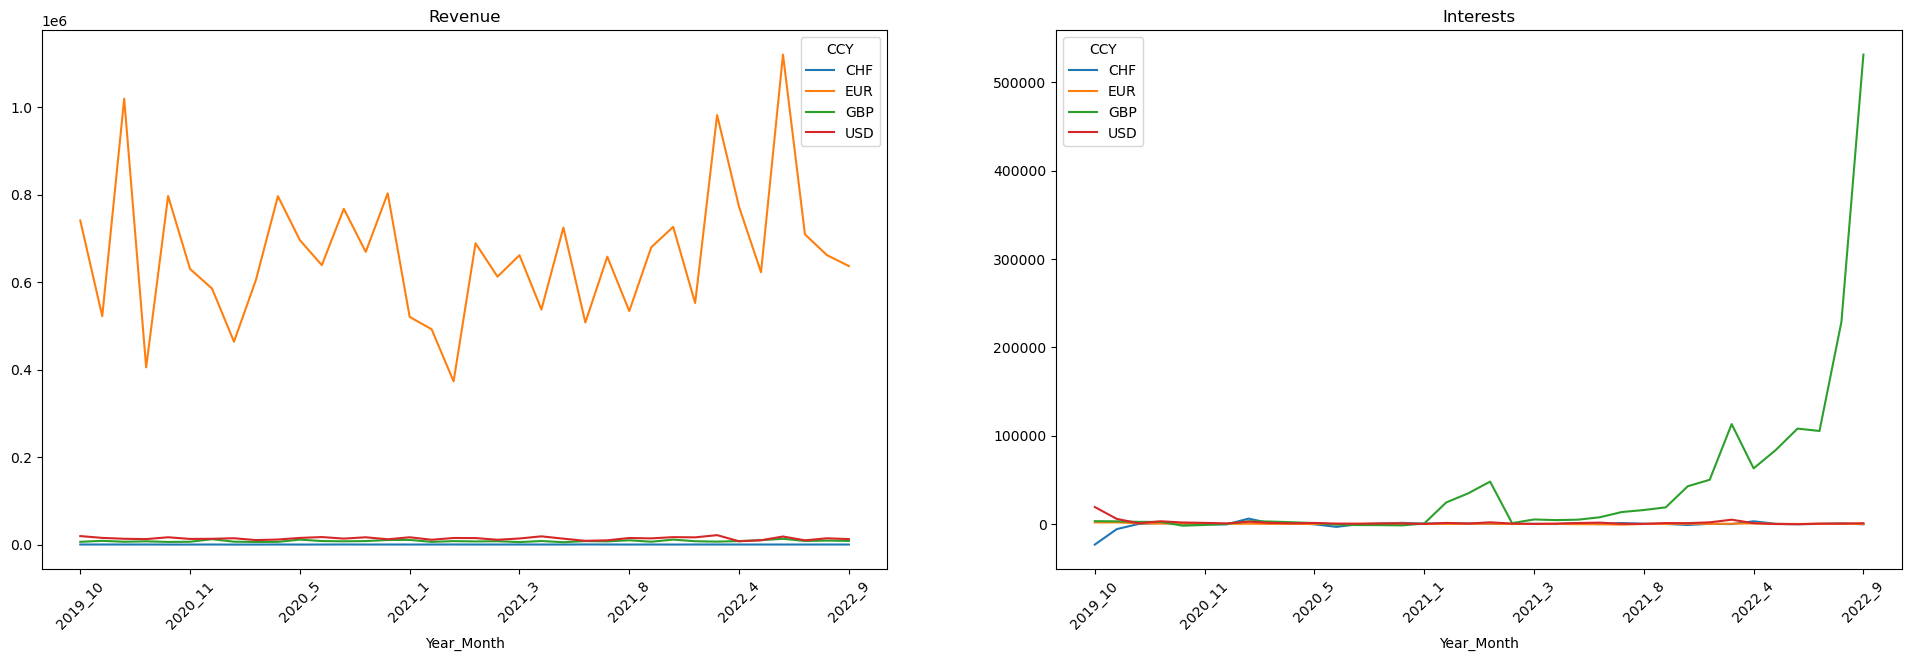

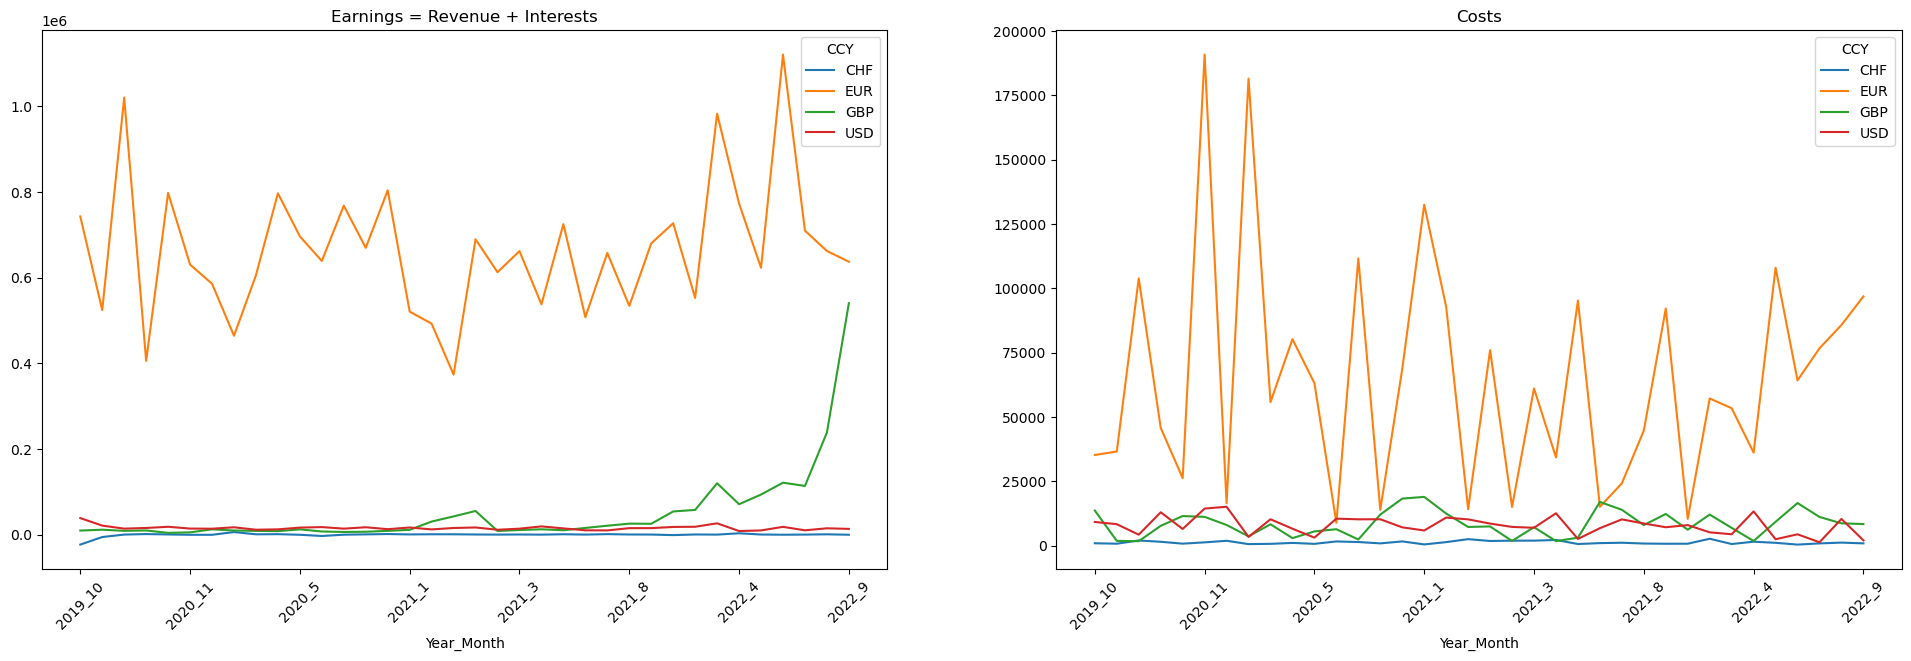

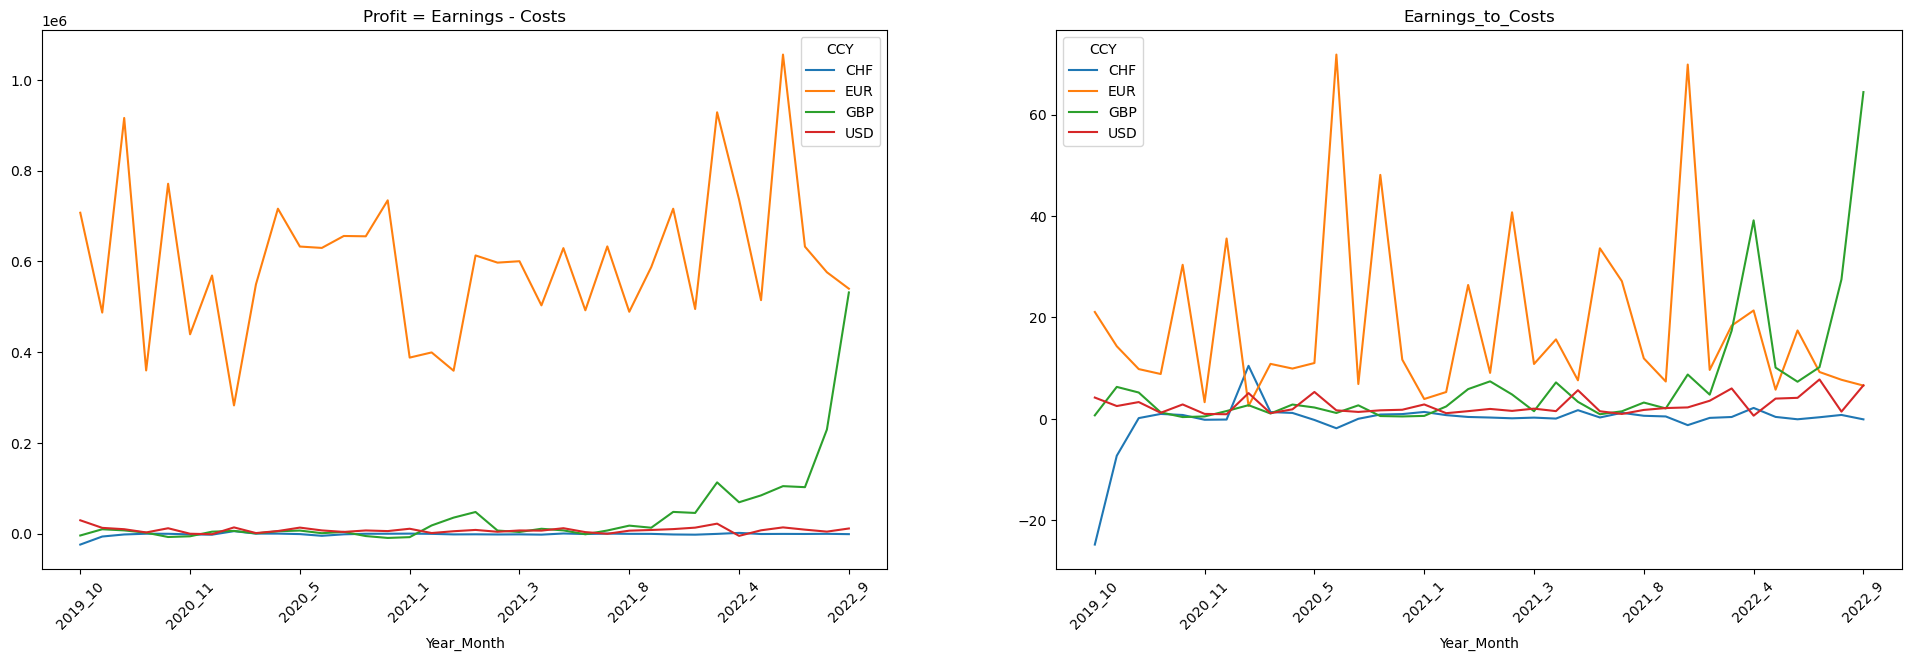

In [12]:
# plot descriptive graphs per month:
ratios_CCY = plot_descriptives_per_moth(df)

### Explorative analysis of the data

#### Average daily values per fiscal year

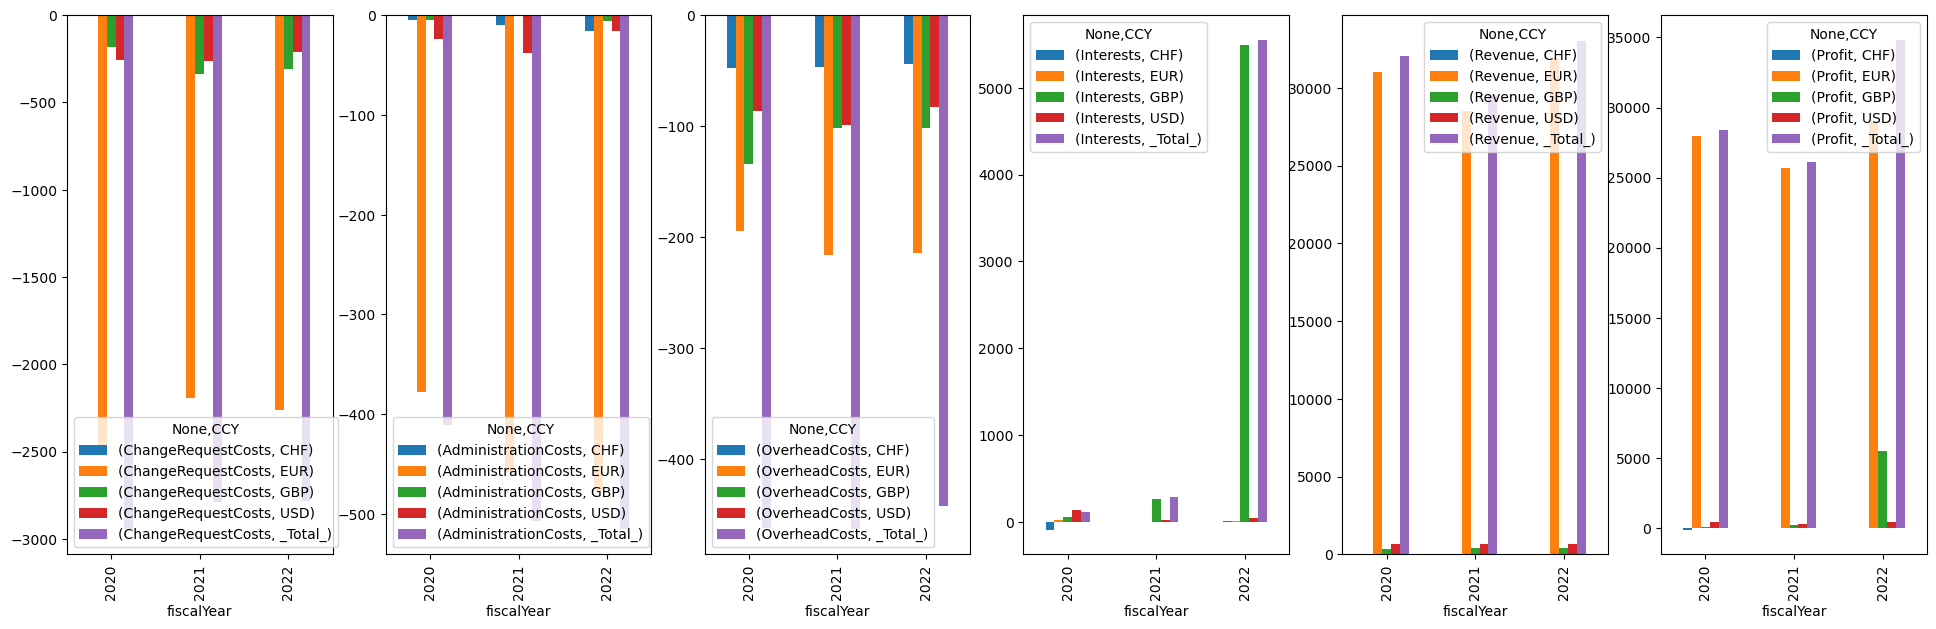

In [13]:
# Show barplots of mean metric values per year: 
fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize = (24, 7))
for i, m in enumerate(metrics):
    total_area_per_class = df[[m,'fiscalYear']].groupby(['fiscalYear','CCY']).mean()
    total_area_per_class.unstack().plot(kind='bar', ax= axs[i])


#### Boxplots of metrics per fiscal year 

Text(0.5, 0.98, 'Boxplots per fiscal year (for total across currencies)')

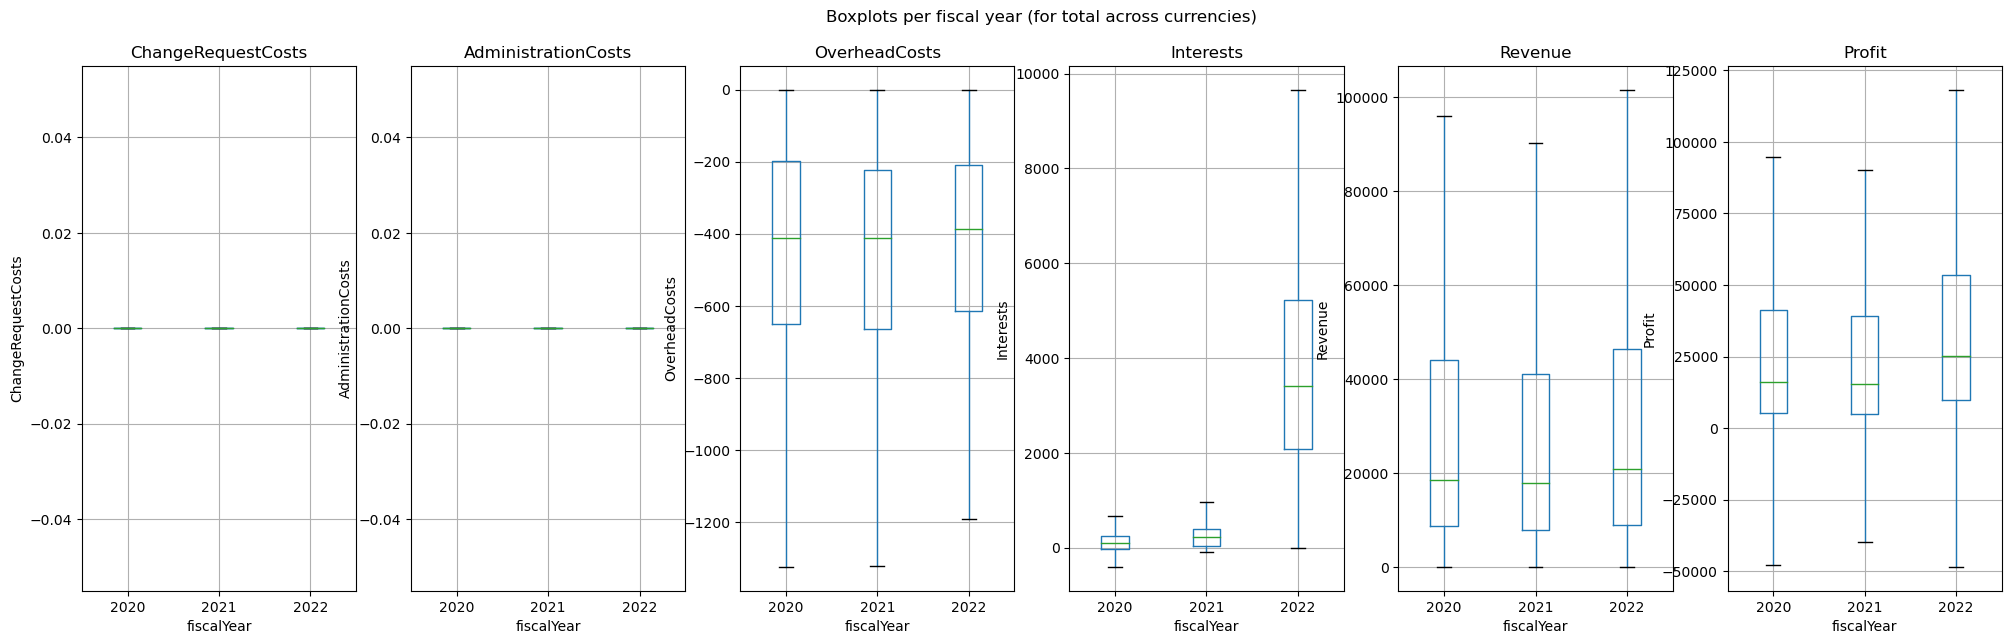

In [14]:
# Show boxplots of metrics per year: 
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize = (24, 7))
for  i, m in enumerate(metrics):
    g = df.loc[df.CCY=='_Total_',[m,'fiscalYear']].boxplot(by=['fiscalYear'],showfliers=0, ax= axs[i])
    g.set_xlabel('fiscalYear'); g.set_ylabel(m)
fig.suptitle('Boxplots per fiscal year (for total across currencies)')

#### Plot the metrics per fiscal year across time

Text(0.5, 0.98, 'Plot per fiscal year (for total across currencies)')

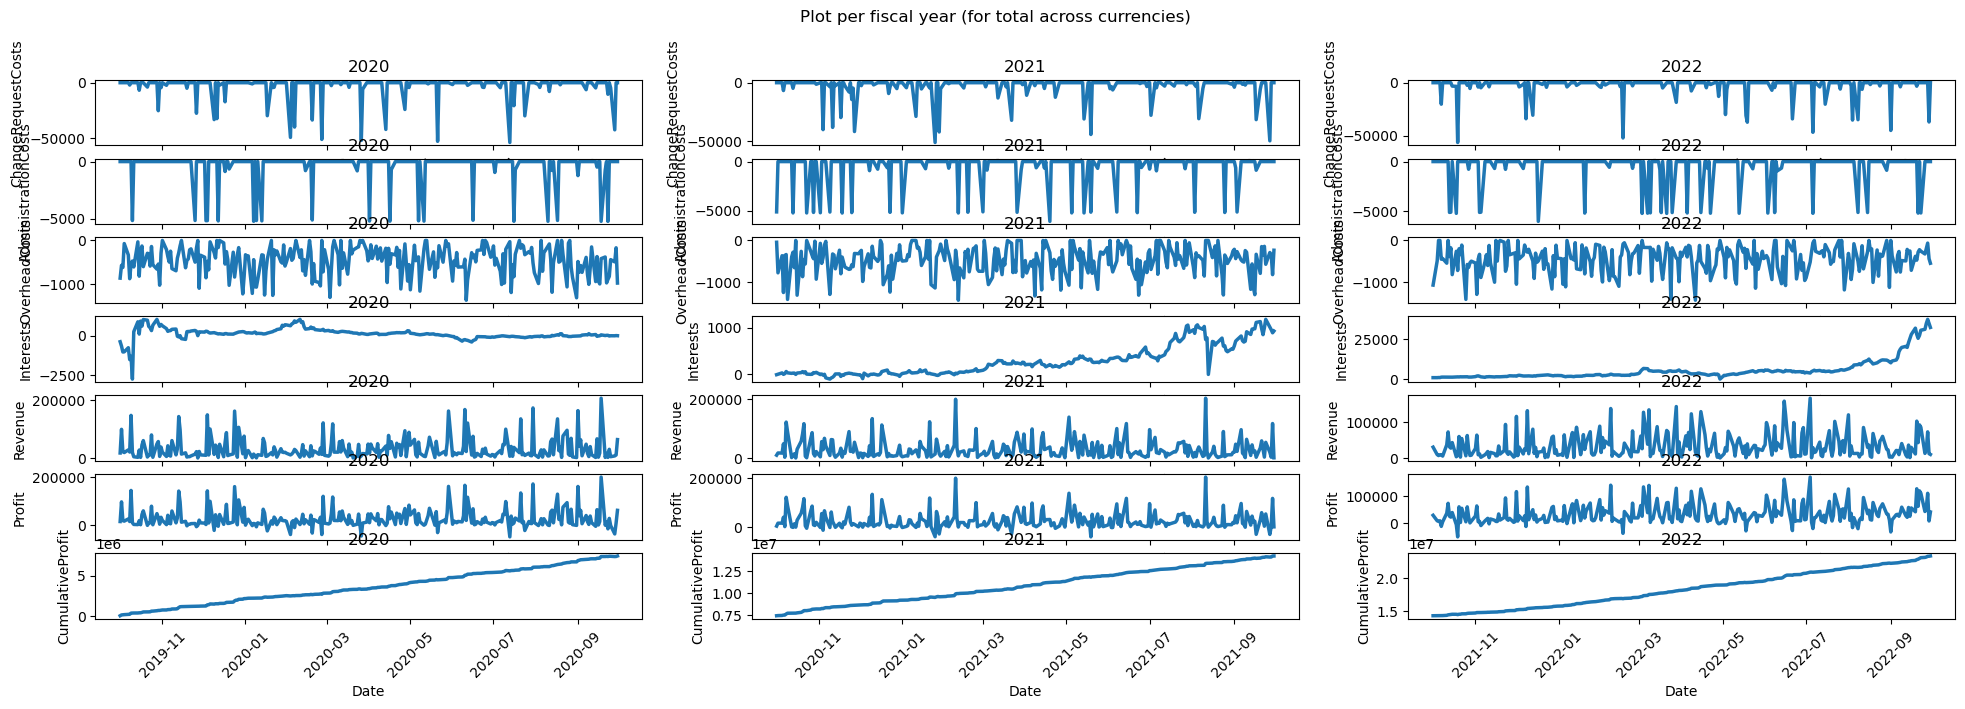

In [15]:
years = np.unique(metrics_per_year_CCY.index.get_level_values('fiscalYear'))
fig, axs = plt.subplots(nrows=len(metrics)+1, ncols=len(years), figsize = (24, 7))
for i, m in enumerate(metrics+['CumulativeProfit']):
    for j, c in enumerate(years):
        g = sns.lineplot(x='Date', y=m, data=df[(df.fiscalYear==c) & (df.CCY=='_Total_')], linewidth=2.5, ax= axs[i][j])
        axs[i][j].tick_params('x', labelrotation=45)
        g.set_title(c)
fig.suptitle('Plot per fiscal year (for total across currencies)')        

#### Autocorrelation of metrics

Text(0.5, 0.98, 'Plot per fiscal year (for total across currencies)')

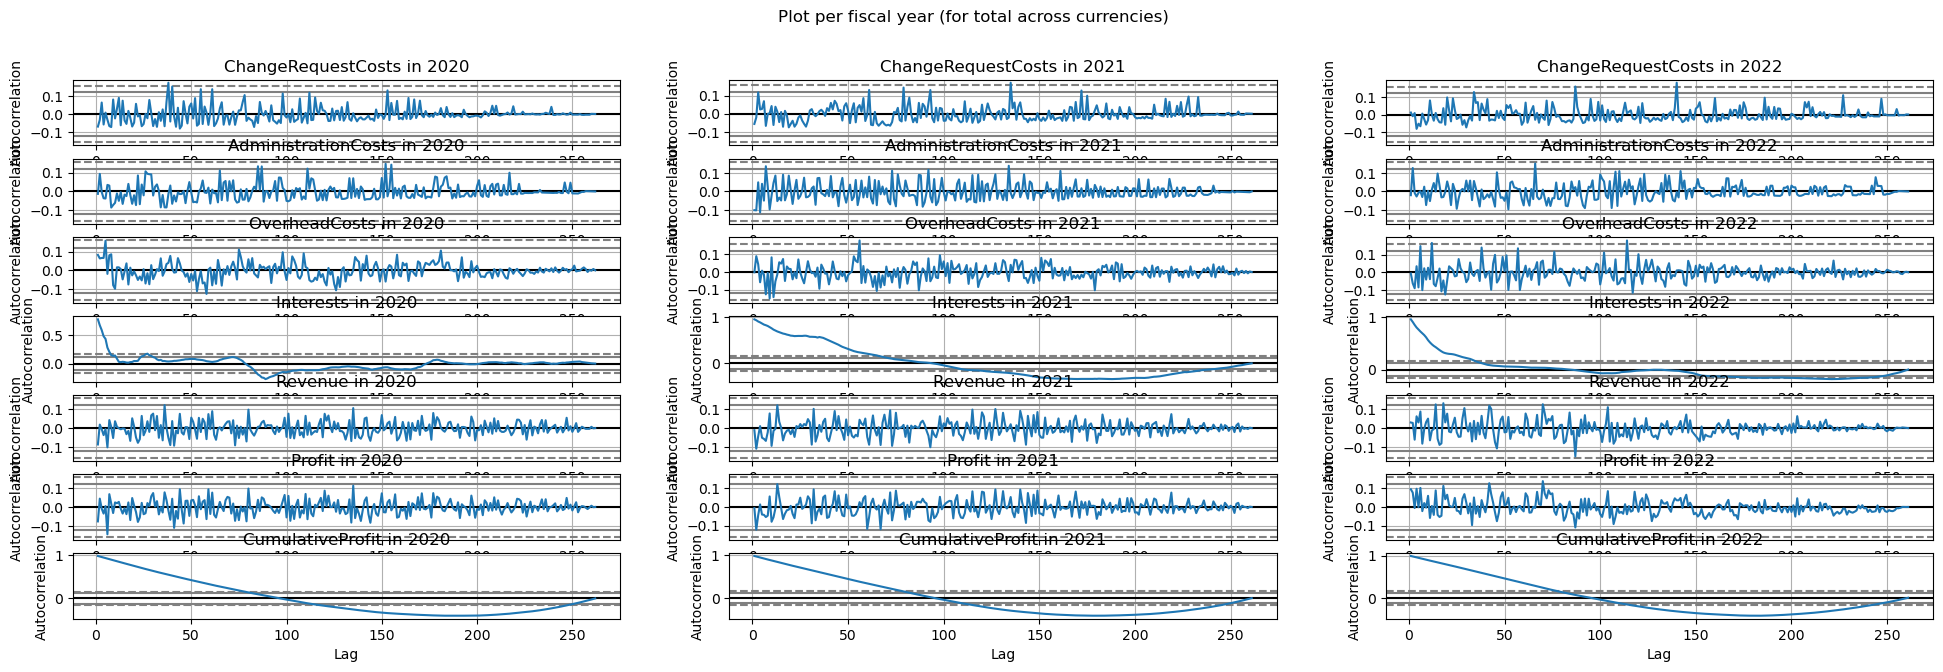

In [16]:
# Show autocorrelation plots
from pandas.plotting import autocorrelation_plot
years = np.unique(metrics_per_year_CCY.index.get_level_values('fiscalYear'))
fig, axs = plt.subplots(nrows=len(metrics)+1, ncols=len(years), figsize = (24, 7))
for i, m in enumerate(metrics+['CumulativeProfit']):
    for j, c in enumerate(years):
        autocorrelation_plot(df.loc[(df.fiscalYear==c) & (df.CCY=='_Total_'),m],ax= axs[i][j]) 
        axs[i][j].set_title(m+' in '+ str(c))
fig.suptitle('Plot per fiscal year (for total across currencies)')            

#### Decompostion of Revenue in Trend, Seasonal component and Residuals

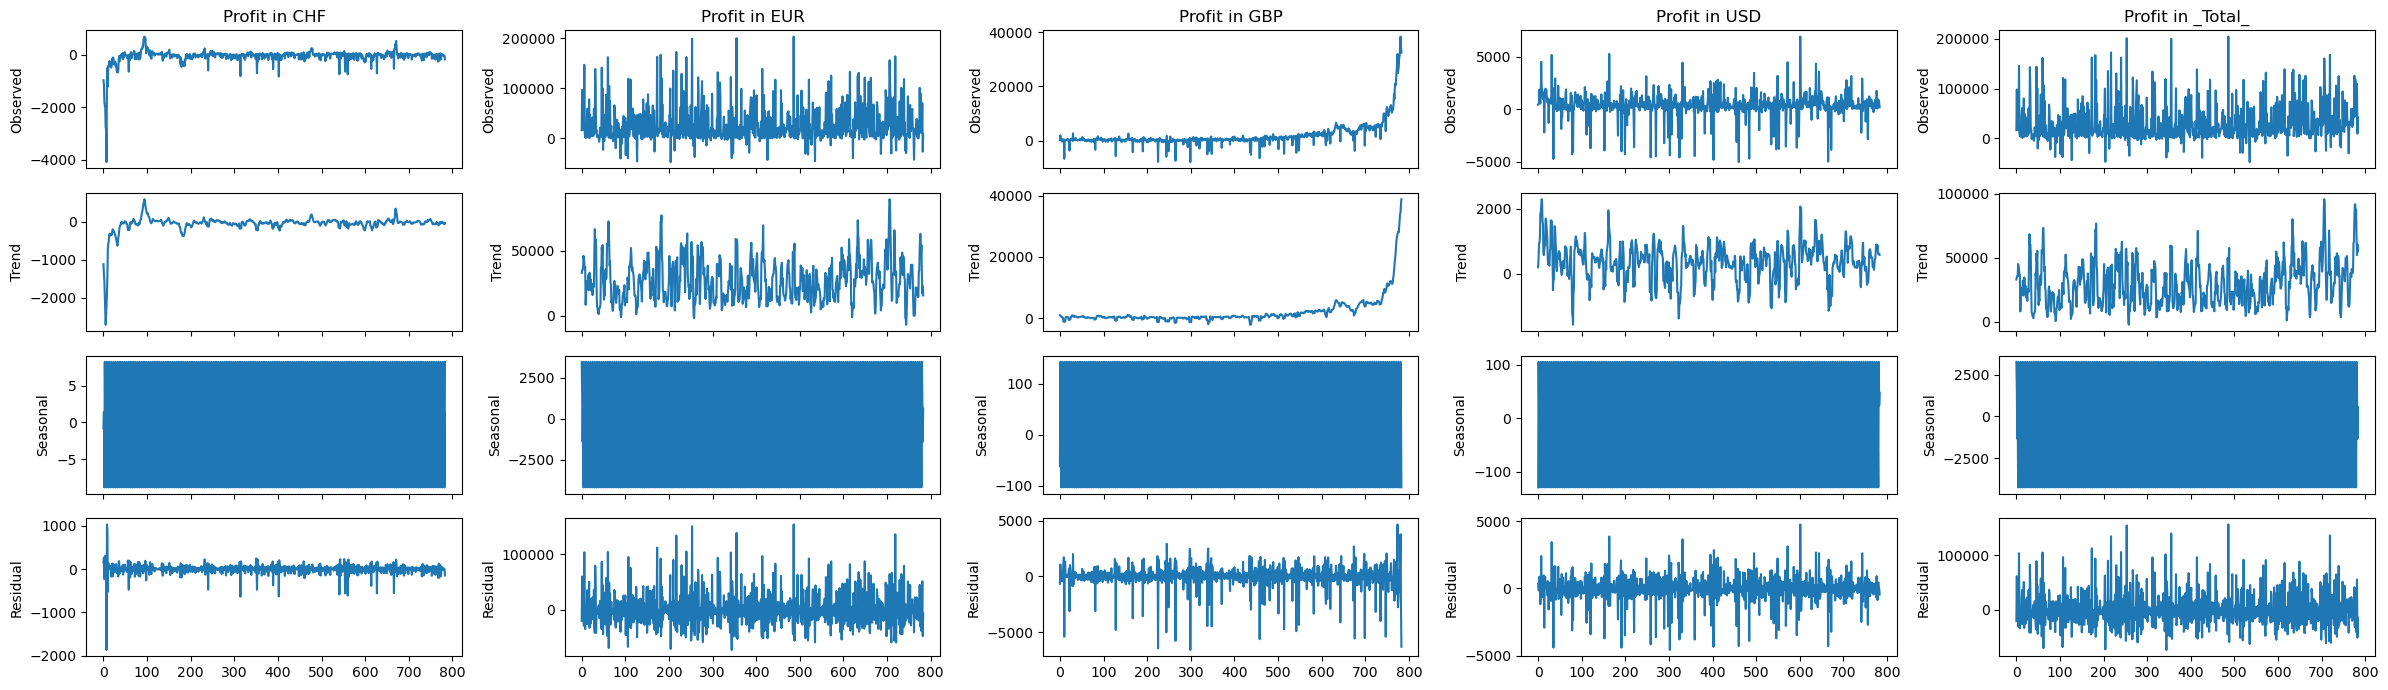

In [17]:
# use the custom function decompose_time_series:

_ = decompose_time_series(df, output_folder_plots = output_folder_plots,  y_var='Profit',  condition_variable = 'CCY')        

## Forecasting analysis

The goal is to predict the profit for the next day using the current day's (and up to five previous days') observed information as features.  
We will train and compare the performance of three statistical models on the entire data except of the last 30 days of observations. We will use the remaining observations as hold-out sample, i.e., test data to evaluate the model's predictions accuracy on. We use the root mean squared error (RMSE) as main measure to determine a model's prediction accuracy, as RMSE is one of the most common measures for regression type analyses.

###  Prepare the data for the forcasting analysis

In [18]:
# prepare data
df1 = df.copy()

# Use  profit as target variable for the forecast analysis
# Reason: profit is the variable of central interest.

df1 = df1.rename(columns={'Profit':'y_var'})

#set date and CCY as index
df1 = df1.set_index([df1.Date, df1.CCY])

#drop date and currency column
df1 = df1.drop(['year','fiscalYear','Date','CCY'], axis=1) 

x_vars = [i for i in df1.columns if i not in ['y_var',  'CumulativeProfit', ]]
print(x_vars)


['ChangeRequestCosts', 'AdministrationCosts', 'OverheadCosts', 'Interests', 'Revenue']


In [19]:
look_back = 5 # number of look-back periods for LSTM model.
LOAD      = 1 # Indicates whether to load the model from a previous model training.


In [20]:

# replace x_vars by lagged variables:
df1 = pd.merge(df1['y_var'], df1[['y_var'] + x_vars].groupby(level='CCY').shift(1) ,left_index=True, right_index=True, suffixes=('', '_lagged'))
# rename lagged variables
df1  = df1.rename(columns={i:i+'_lagged' for i in x_vars})
x_vars = [i+'_lagged' for i in x_vars]
print(['x_vars :']+x_vars)


['x_vars :', 'ChangeRequestCosts_lagged', 'AdministrationCosts_lagged', 'OverheadCosts_lagged', 'Interests_lagged', 'Revenue_lagged']


In [21]:
# add additional lagged variables for LSTM model:
if look_back > 1:
    for i in range(1,look_back):
        df1 = add_lagged(df1, x_vars, lag=i)

x_vars_plus = [i for i in df1.columns if i not in ['y_var']]
print(['x_vars_plus :']+x_vars_plus)


['x_vars_plus :', 'y_var_lagged', 'ChangeRequestCosts_lagged', 'AdministrationCosts_lagged', 'OverheadCosts_lagged', 'Interests_lagged', 'Revenue_lagged', 'y_var_lagged2', 'ChangeRequestCosts_lagged2', 'AdministrationCosts_lagged2', 'OverheadCosts_lagged2', 'Interests_lagged2', 'Revenue_lagged2', 'y_var_lagged3', 'ChangeRequestCosts_lagged3', 'AdministrationCosts_lagged3', 'OverheadCosts_lagged3', 'Interests_lagged3', 'Revenue_lagged3', 'y_var_lagged4', 'ChangeRequestCosts_lagged4', 'AdministrationCosts_lagged4', 'OverheadCosts_lagged4', 'Interests_lagged4', 'Revenue_lagged4', 'y_var_lagged5', 'ChangeRequestCosts_lagged5', 'AdministrationCosts_lagged5', 'OverheadCosts_lagged5', 'Interests_lagged5', 'Revenue_lagged5']


In [22]:

# remove rows where all values are missing
# Reason: missing data due to using lagged values.
idx = pd.IndexSlice
mask = ~df1.isna().any(axis=1)
print('Number of observations before cleaning days of missing data: %s'%len(df1))
df1 = df1.loc[idx[mask, :, :], :]
print('Number of observations before cleaning days of missing data: %s'%len(df1))

Number of observations before cleaning days of missing data: 3920
Number of observations before cleaning days of missing data: 3895


In [23]:
# split the data in a training and a test set:
horizon = 30
#take last week of the dataset for validation
inx_day = np.unique(df1.index.get_level_values('Date'))[-horizon]

df1_train, df1_test = df1.iloc[df1.index.get_level_values('Date')<inx_day], df1.iloc[df1.index.get_level_values('Date')>=inx_day]


#### Autoregressive moving average model

#### Differencing needed?

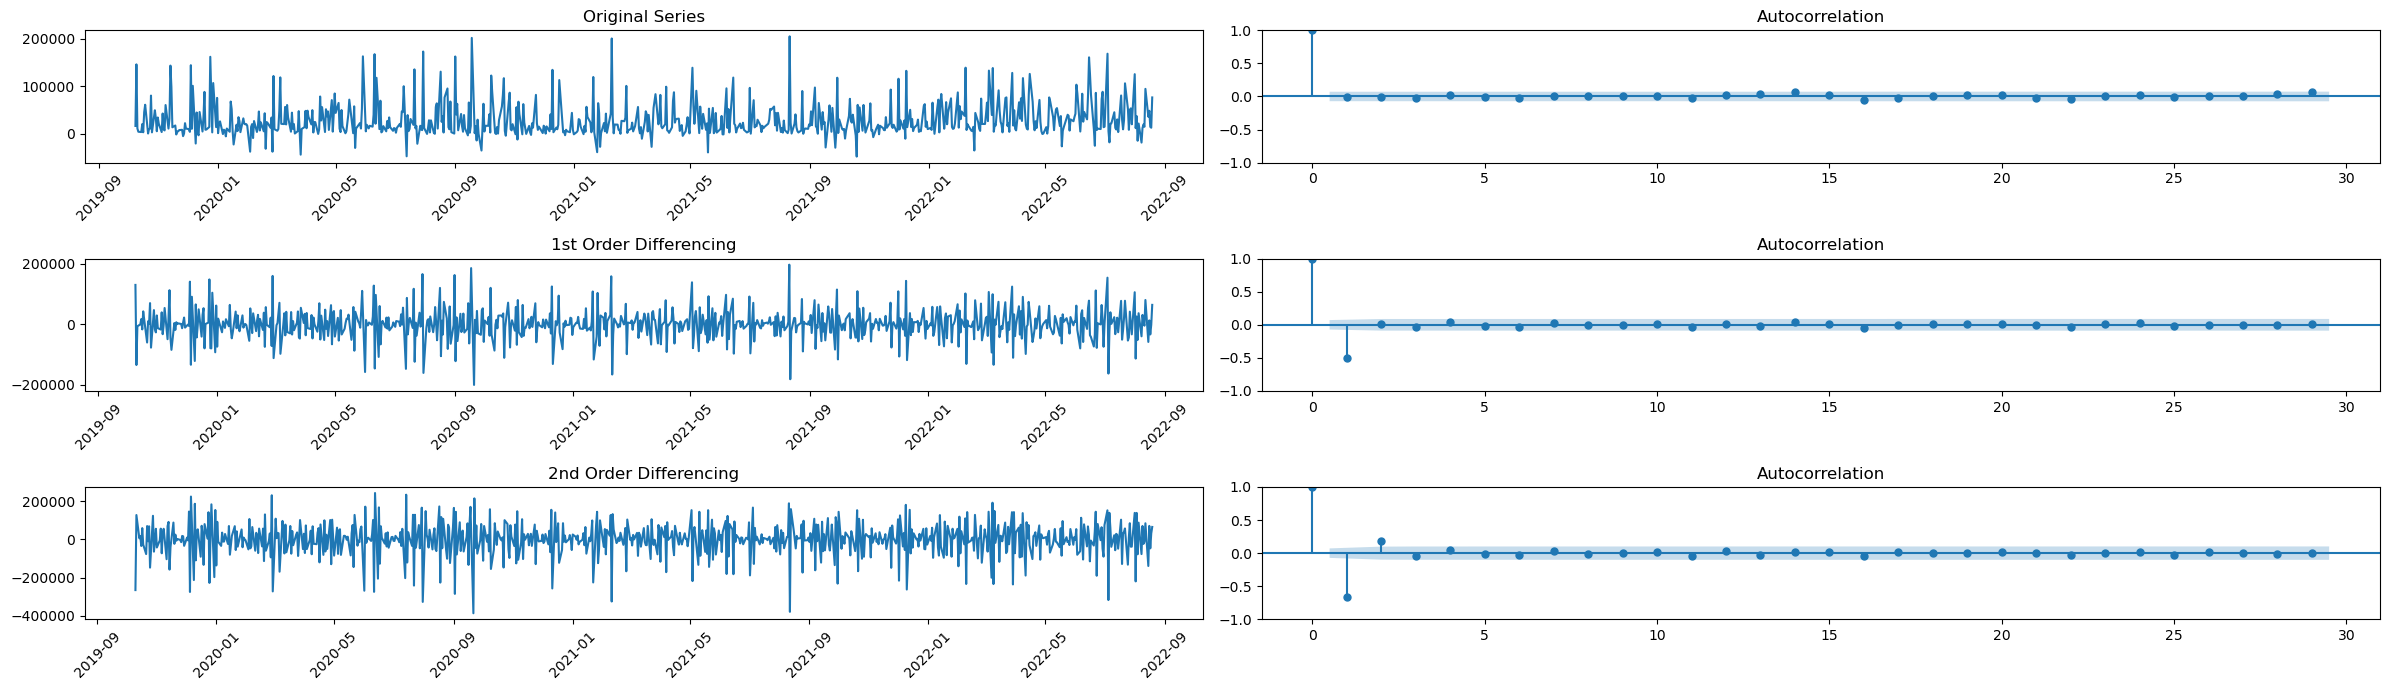

In [24]:
# visual inspection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(24,7)}) 

y_train_total = df1_train[df1_train.index.get_level_values('CCY')=='_Total_'].y_var.droplevel('CCY')

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(y_train_total); axes[0, 0].set_title('Original Series')
axes[0, 0].tick_params('x', labelrotation=45)
plot_acf(y_train_total, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_train_total.diff()); axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].tick_params('x', labelrotation=45)
plot_acf(y_train_total.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_train_total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].tick_params('x', labelrotation=45)
plot_acf(y_train_total.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()


In [25]:
# run tests:
from pmdarima.arima.utils import ndiffs

## Adf Test
print(ndiffs(y_train_total, test='adf')  )

# KPSS test
print(ndiffs(y_train_total, test='kpss') ) 

# PP test:
print(ndiffs(y_train_total, test='pp')  )

0
1
0


Visual inspection and tests indicate that 1st order differencing is needed for a stationary time series. 

#### Autocorrelation?

[(0.0, 1.2)]

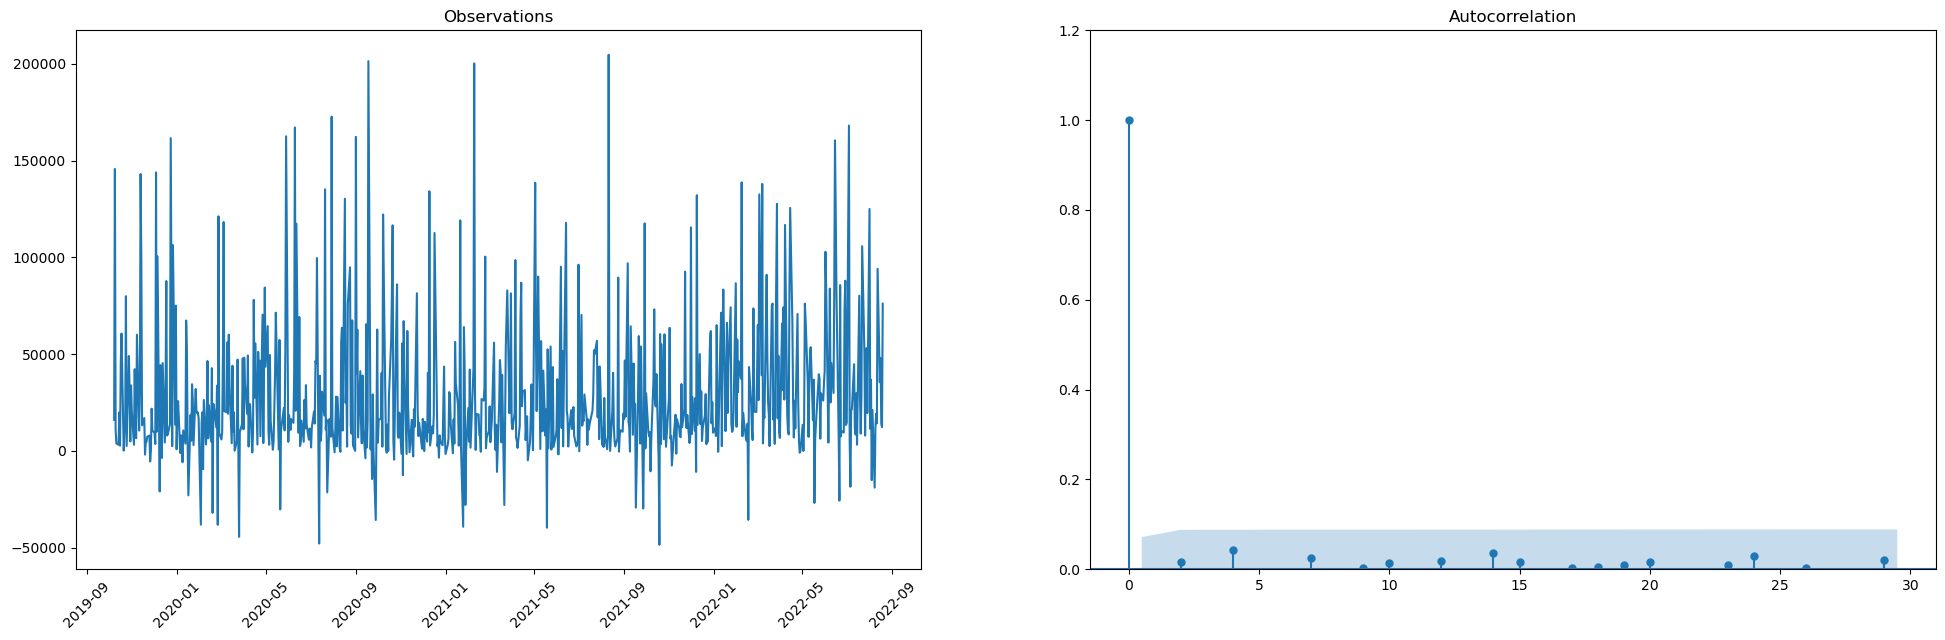

In [26]:
plt.rcParams.update({'figure.figsize':(24,7)})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_train_total); axes[0].set_title('Observations')
#axes[0].plot(y_train_total.diff()); axes[0].set_title('1st Order Differencing')
plot_acf(y_train_total.diff().dropna(), ax=axes[1])
axes[0].tick_params('x', labelrotation=45)
axes[1].set(ylim=(0,1.2))

The autocorrelation plot does not indicate autocorrelation of the time series.

#### Partial Autocorrelation?

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[(0.0, 5.0)]

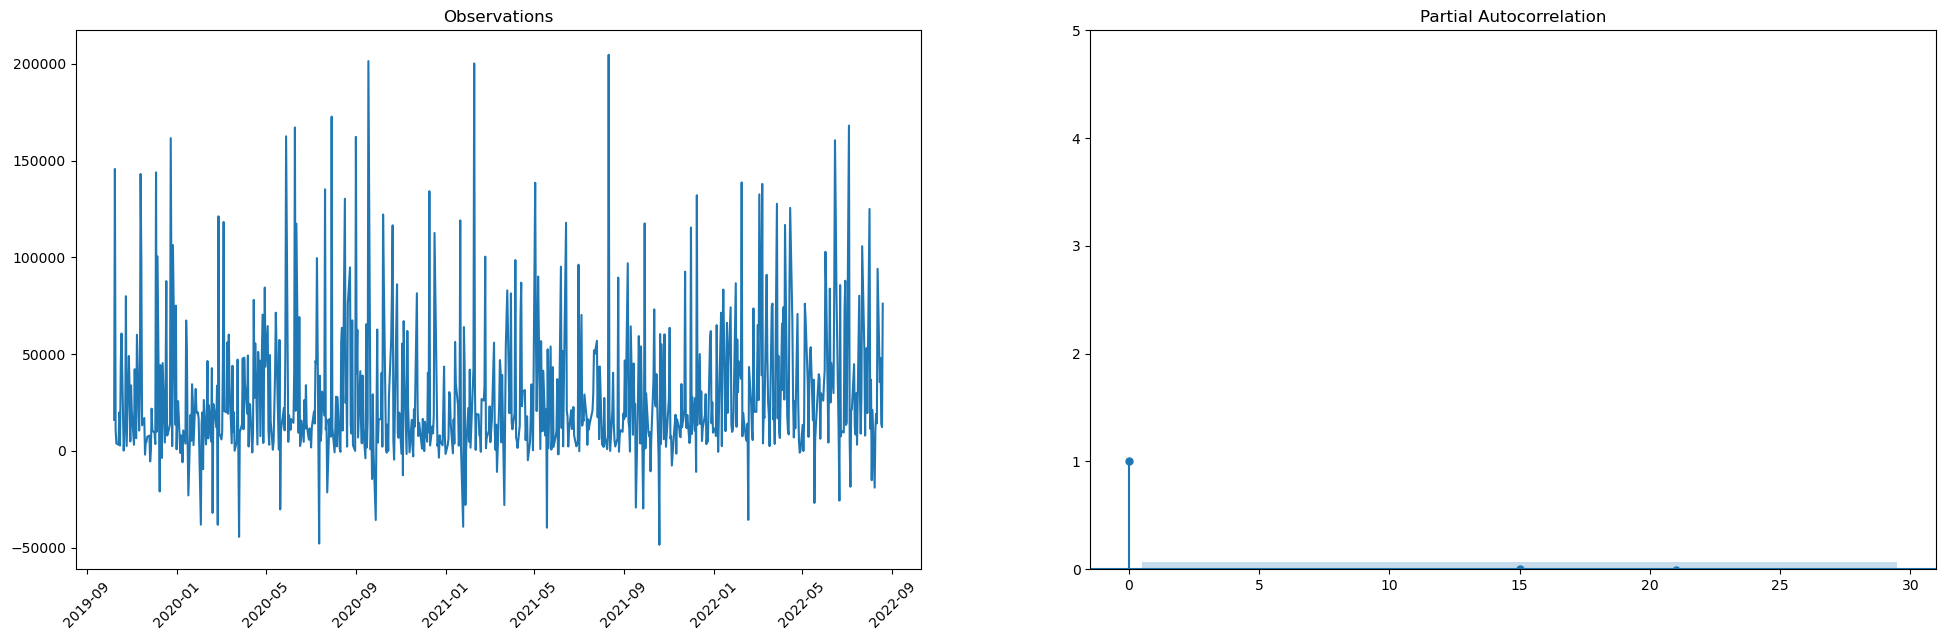

In [27]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(24,7)})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_train_total); axes[0].set_title('Observations')
#axes[0].plot(y_train_total.diff()); axes[0].set_title('1st Order Differencing')
axes[0].tick_params('x', labelrotation=45)
plot_pacf(y_train_total.diff().dropna(), ax=axes[1])
axes[1].set(ylim=(0,5))



The partial autocorrelation plot does not indicate partial autocorrelation of the time series.

### Model 1: SARIMA with exogoneous variables

In [28]:
# initialize results variables 
smodels       = dict()
res_stats_in  = pd.DataFrame()
res_stats_out = pd.DataFrame()
res_stats_out_train_only = pd.DataFrame()

# set the considered currencies
currencies =  ['EUR', 'USD', 'GBP', 'CHF','_Total_']


In [29]:
# run the SARIMA model
# SARIMA stands for Seasonal Autoregressive Integrated Moving Average 
# use a seasonal differencing of m=5 for the daily data (there is no data for Saturday and Sunday).
for c in currencies:
    smodels = get_arima(df1_train, smodels, x_vars, c = c, output_folder_model =  output_folder_model, LOAD = LOAD)


----------------------------------------------------------------------------------------------------
SARIMA model for EUR

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  749
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -8925.145
Date:                Fri, 23 Jun 2023   AIC                          17866.290
Time:                        07:42:41   BIC                          17903.240
Sample:                    10-08-2019   HQIC                         17880.529
                         - 08-19-2022                                         
Covariance Type:                  opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                   8162.7890   7730.694      

#### In-Sample performance

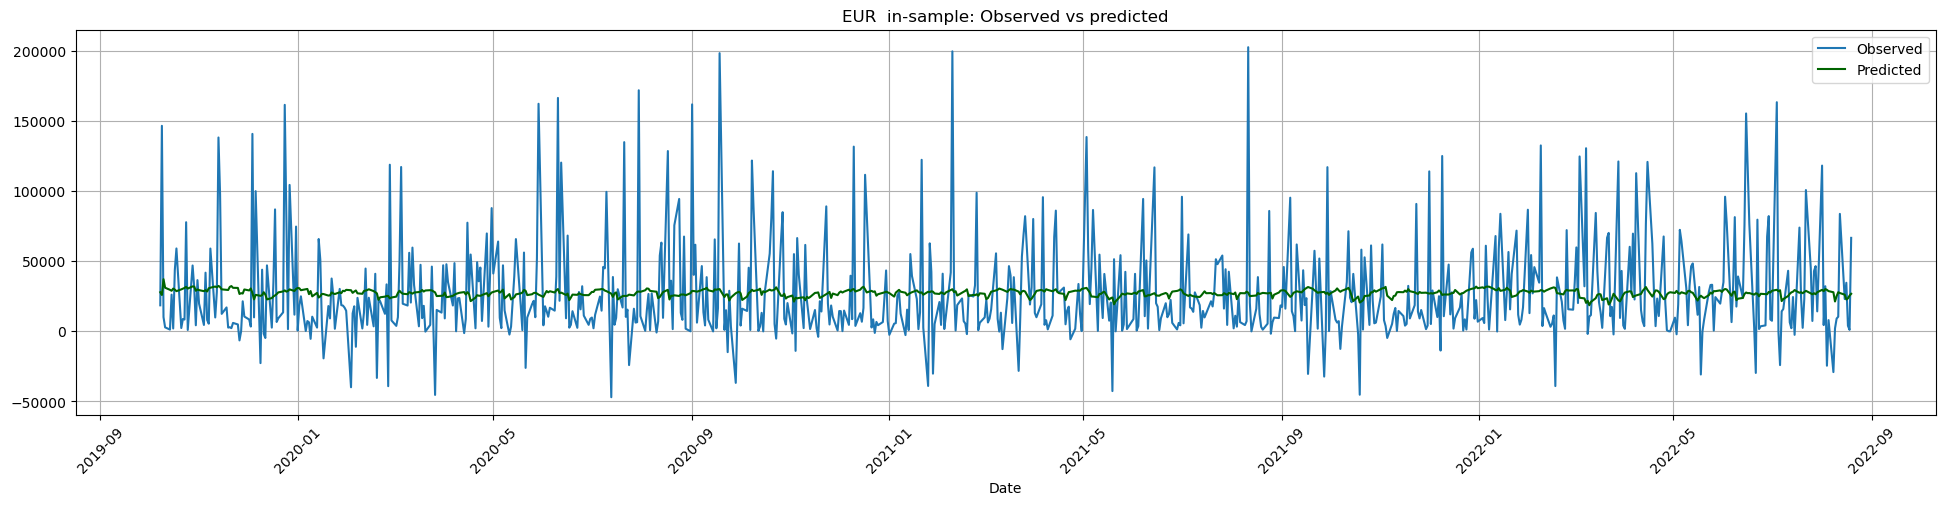

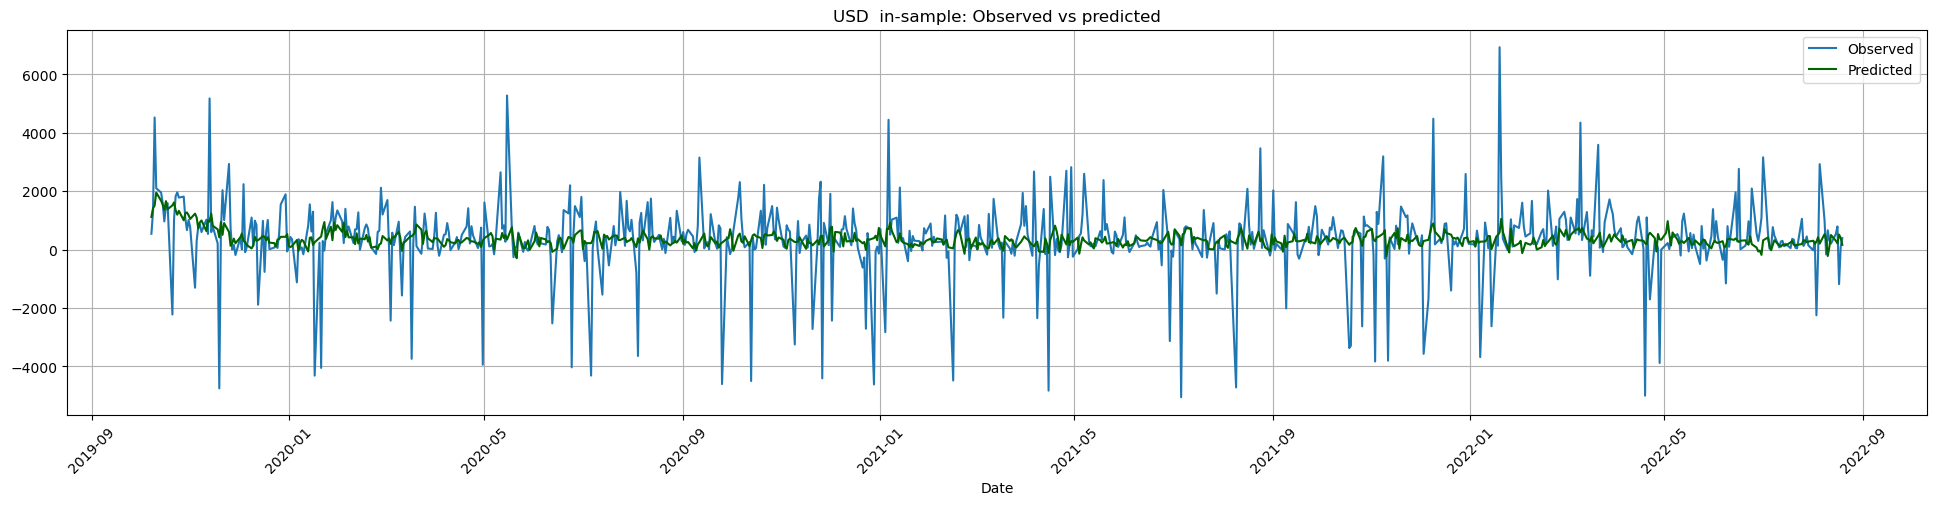

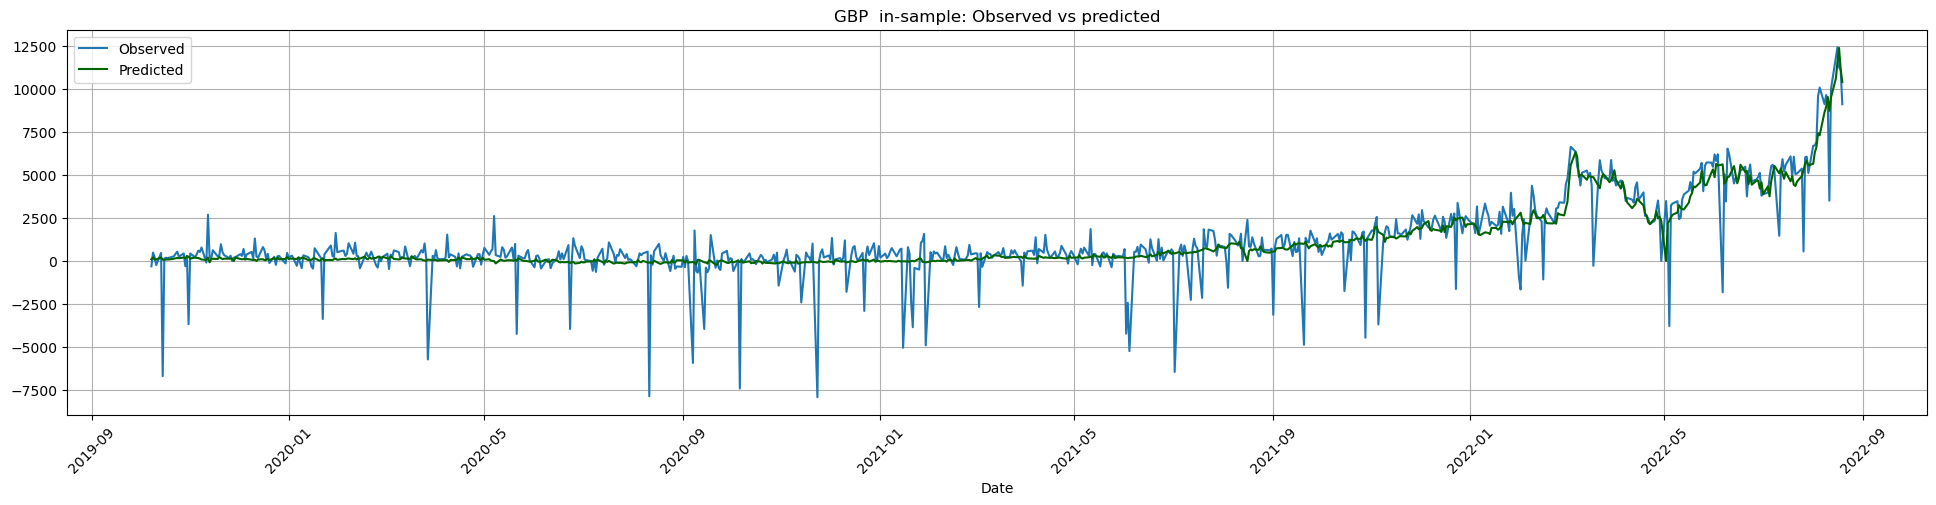

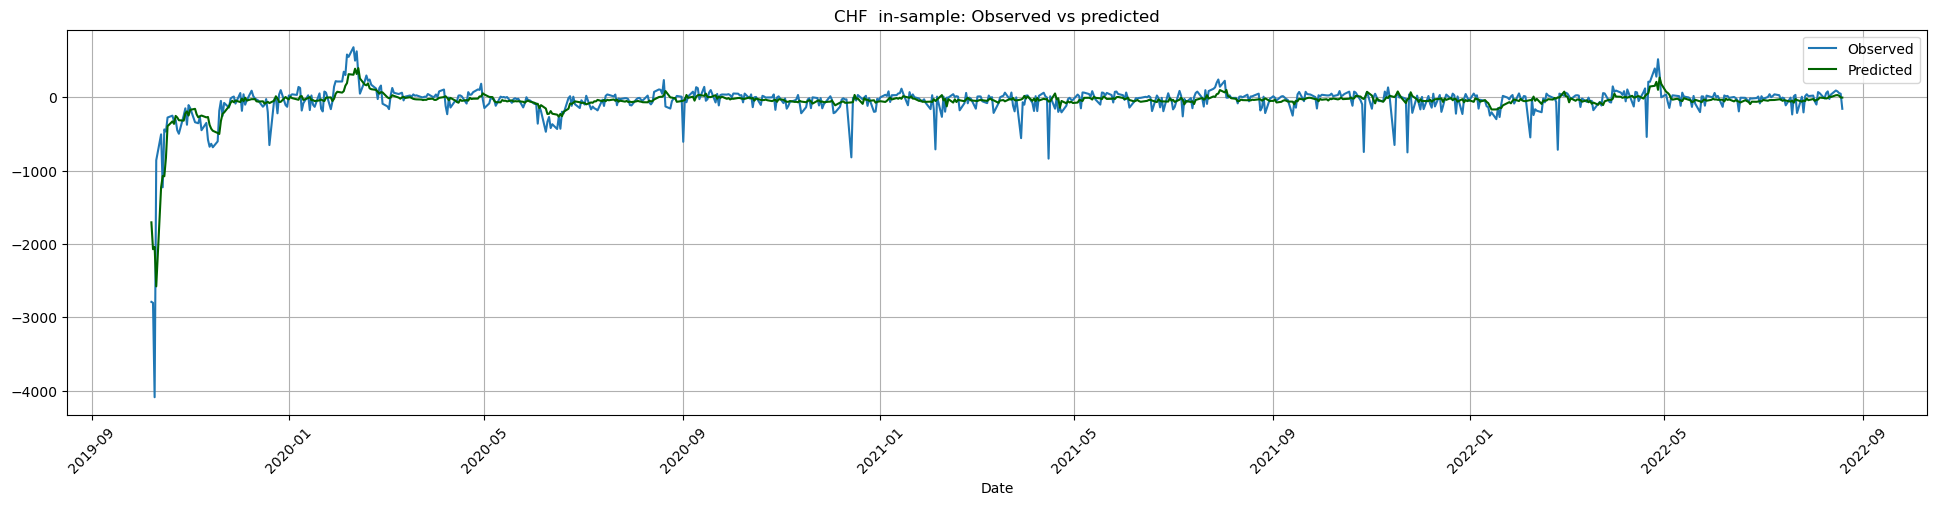

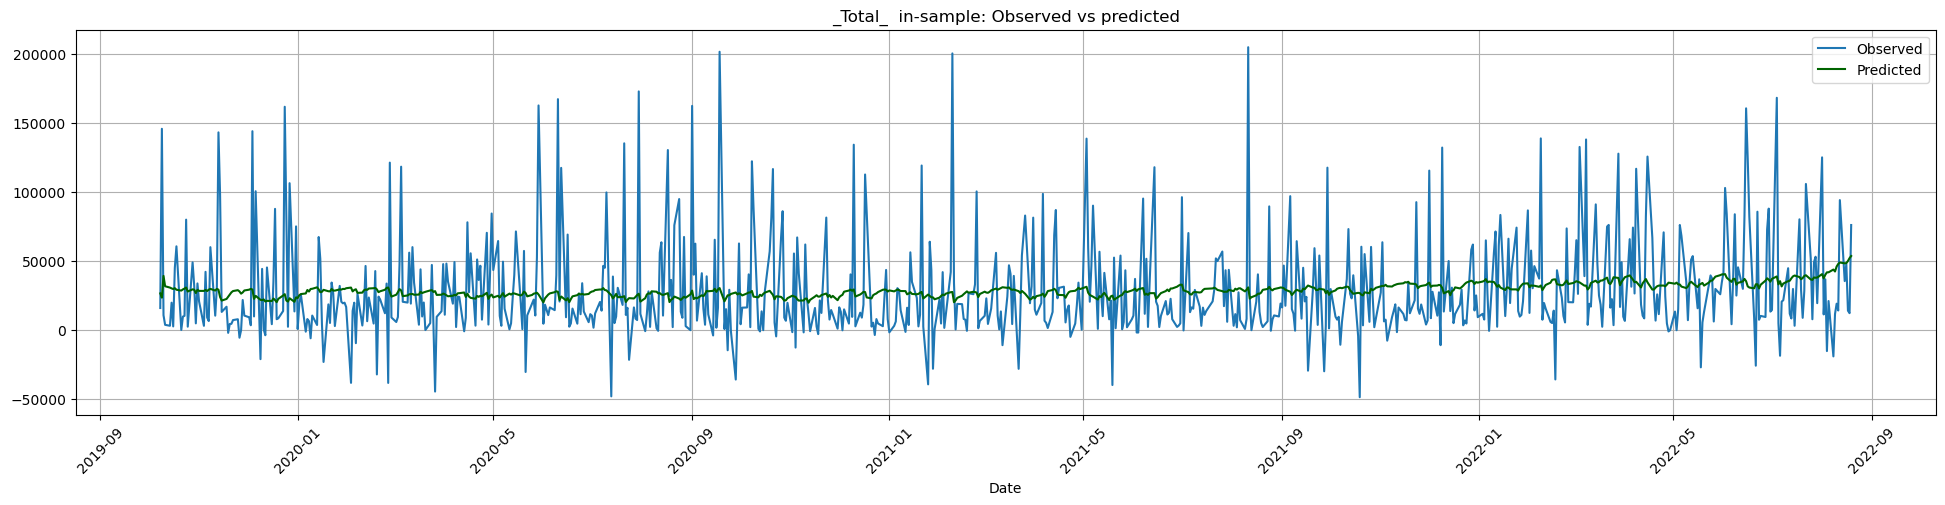

In [51]:
for c in currencies:
    res_stats_in = get_error_stats_in(df1_train, smodels, res_stats_in, x_vars, c = c)

In [31]:
# show in-sample error statistics:
# adjust display settings:
pd.options.display.float_format =  '{:,.1f}'.format
res_stats_in

EUR       USD       GBP       CHF  \
Root mean squared error           36,189.7   1,214.1   1,266.6     169.9   
Mean absolute error               26,383.7     703.2     659.4      92.7   
Median absolute error             20,897.3     360.2     357.8      59.4   
Total observed Profit         20,647,393.8 269,690.6 878,798.0 -41,430.7   
Total predicted Profit        20,515,678.2 270,120.1 876,846.0 -40,316.4   
Percentage error total Profit         -0.6       0.2      -0.2      -2.7   
Explained variance                     0.0       0.0       0.7       0.6   
Correlation                            0.0       0.2       0.8       0.8   

                                   _Total_  
Root mean squared error           36,304.3  
Mean absolute error               26,344.2  
Median absolute error             20,712.1  
Total observed Profit         21,754,451.7  
Total predicted Profit        21,693,598.8  
Percentage error total Profit         -0.3  
Explained variance                     0.0  
Correlation                            0.1

#### Forecast: Out-of-Sample performance

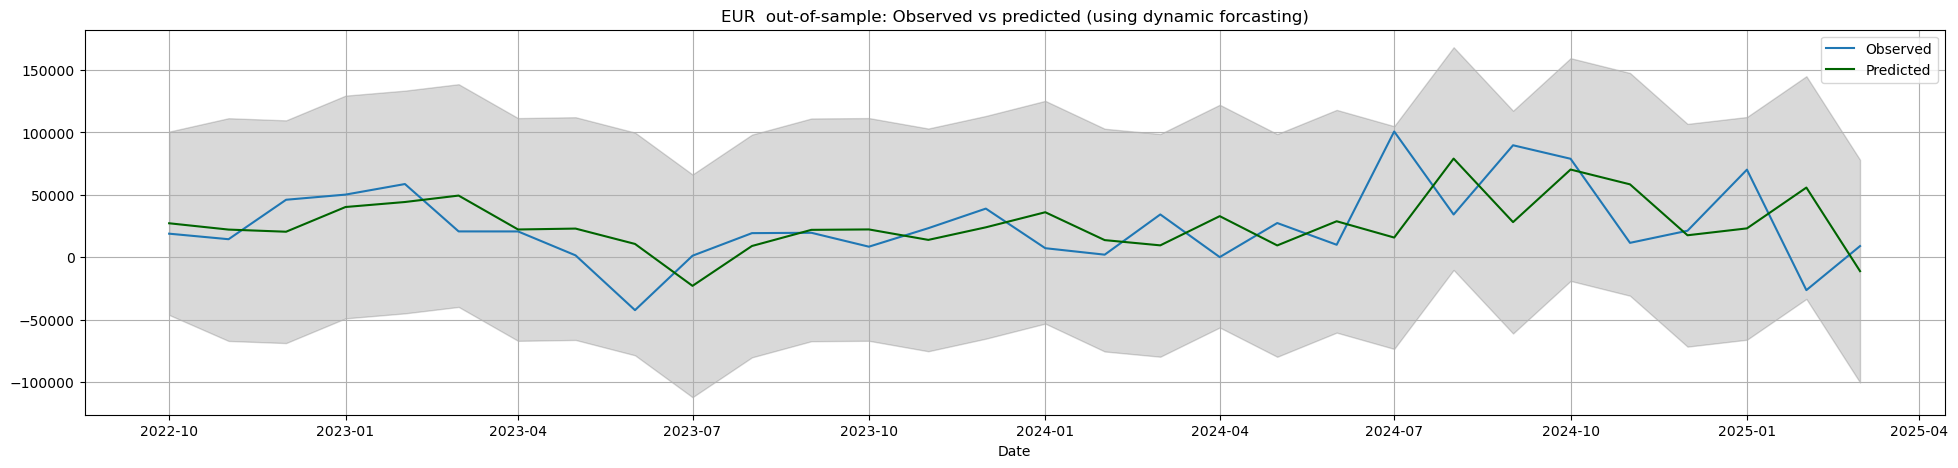

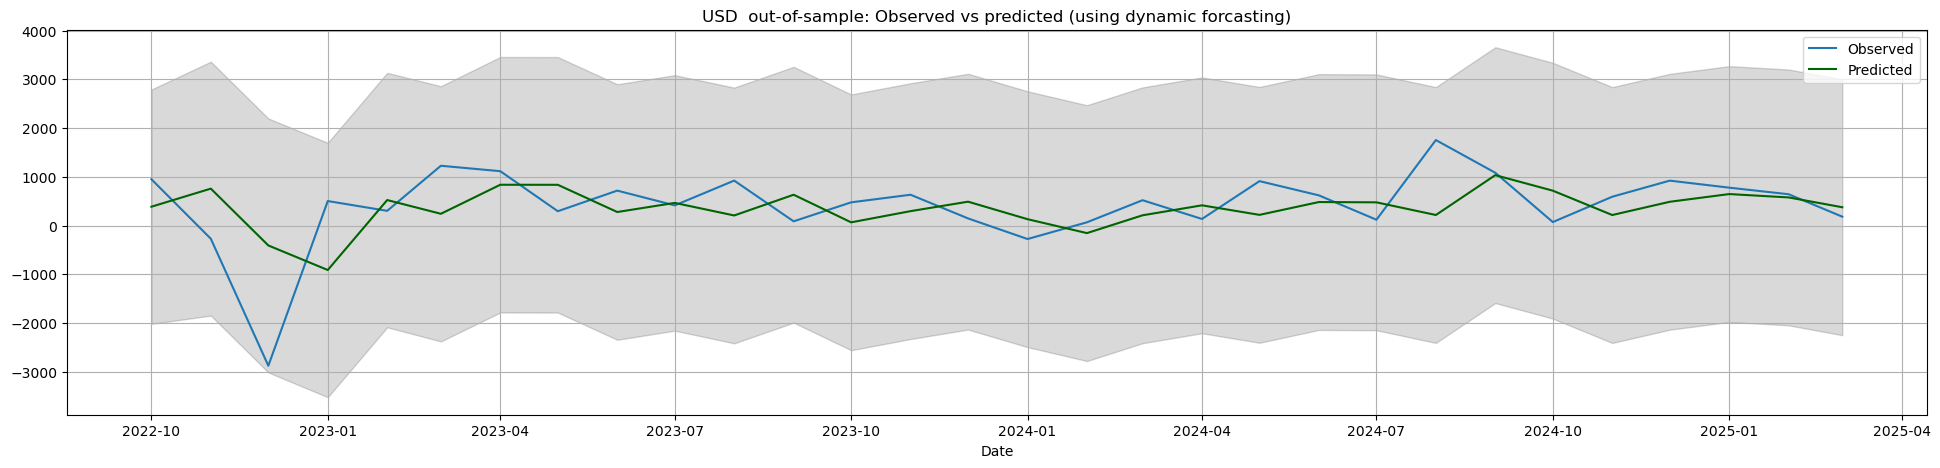

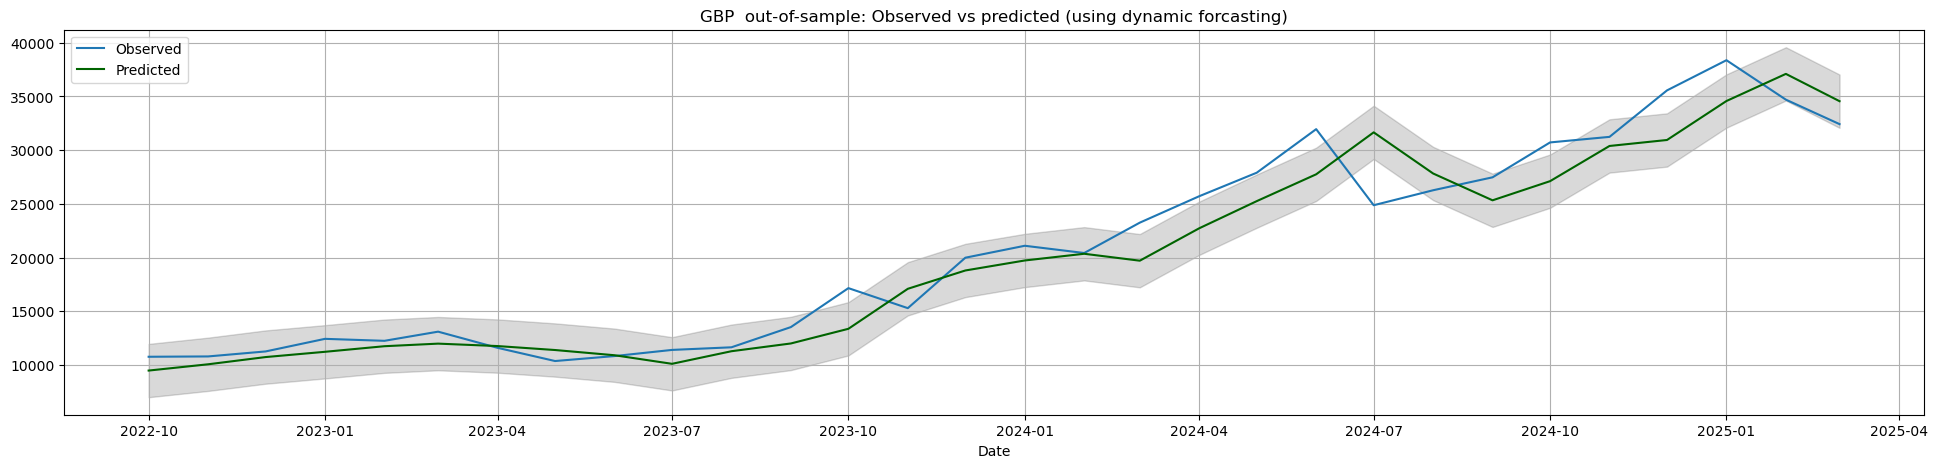

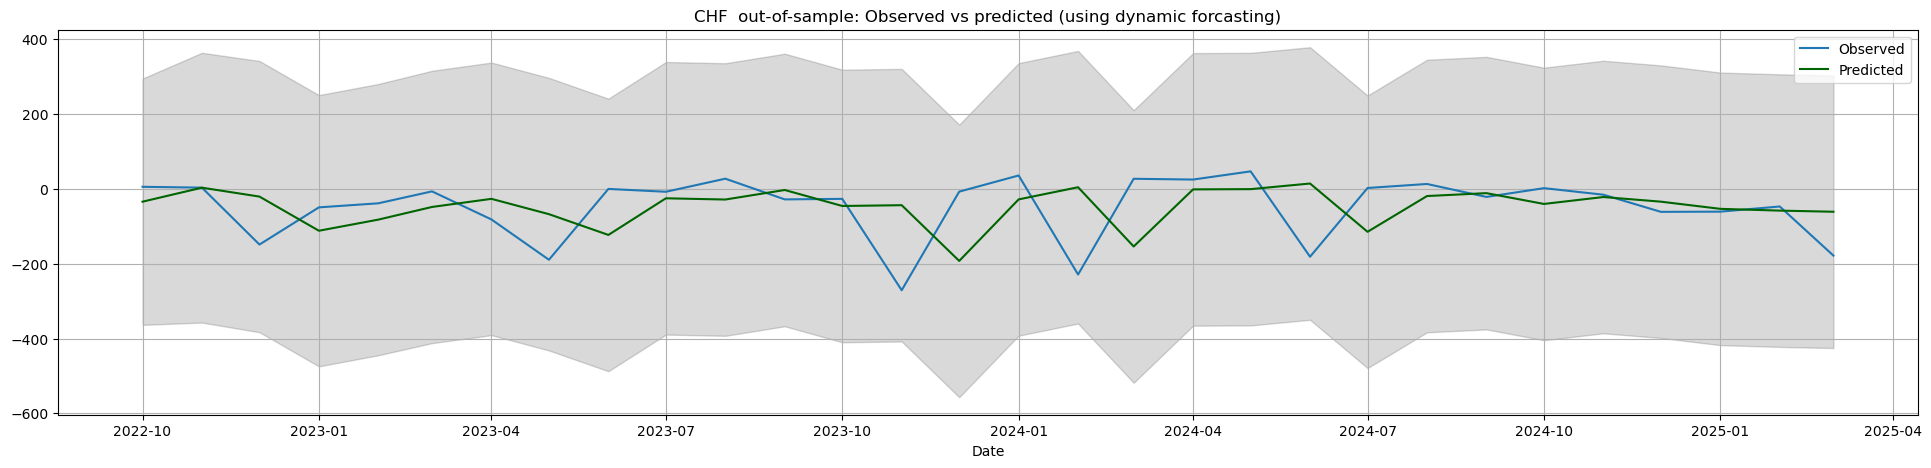

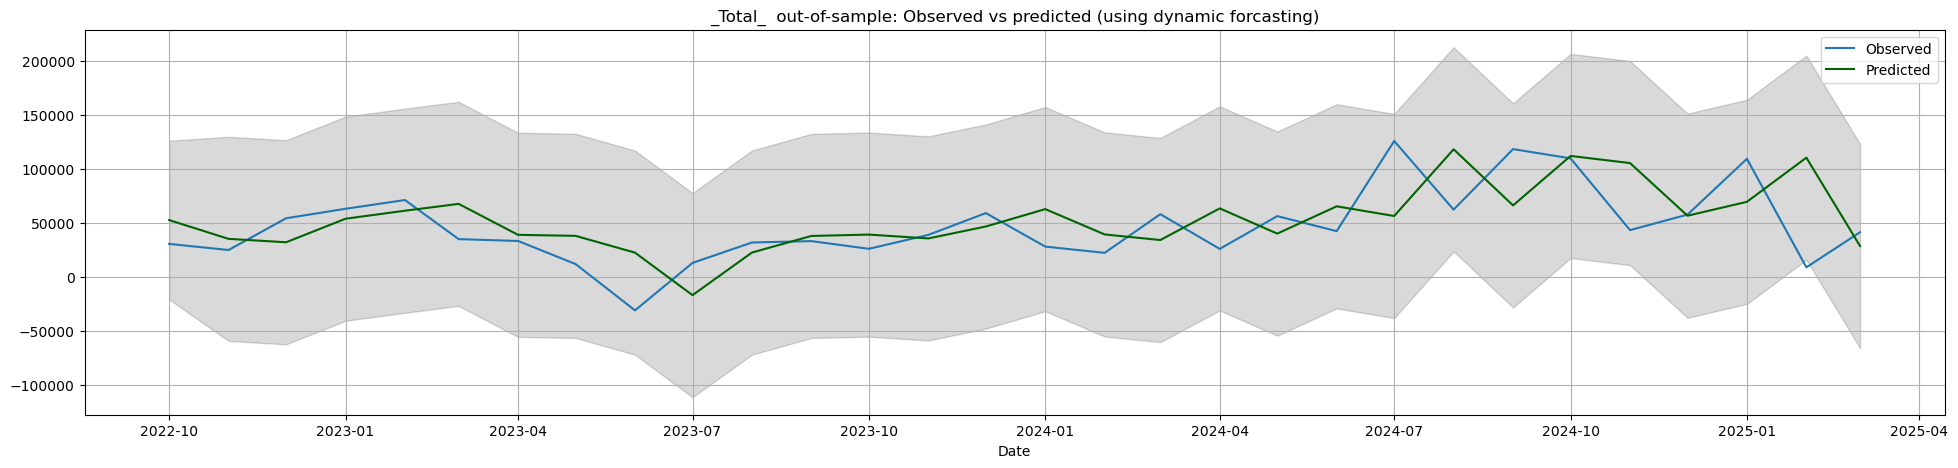

In [32]:
# Using dynamic forecasting:
for c in currencies:    
    res_stats_out = get_error_stats_out(df1_test, smodels,  res_stats_out, x_vars, horizon,  c = c)

In [33]:
# show out-of-sample error statistics using dynamic forecasting:
res_stats_out

EUR      USD       GBP      CHF  \
Root mean squared error        33,846.3    740.6   2,520.2    102.1   
Mean absolute error            26,002.6    539.4   1,977.0     75.5   
Median absolute error          19,455.6    391.3   1,447.5     45.6   
Total observed Profit         771,494.6 12,741.9 624,227.9 -1,456.9   
Total predicted Profit        797,011.9 10,726.1 596,821.8 -1,423.8   
Percentage error total Profit       3.3    -15.8      -4.4     -2.3   
Explained variance                 -0.2      0.1       0.9     -0.5   
Correlation                         0.2      0.3       1.0     -0.2   

                                  _Total_  
Root mean squared error          35,567.0  
Mean absolute error              27,071.4  
Median absolute error            22,098.5  
Total observed Profit         1,407,007.4  
Total predicted Profit        1,597,365.0  
Percentage error total Profit        13.5  
Explained variance                   -0.1  
Correlation                           0.4

In [34]:
# Using training data only:
if 0:
    for c in currencies:
        res_stats_out_train_only = get_error_stats_out(df1_test, smodels, res_stats_out_train_only, x_vars, horizon, c = c, DYNAMIC_FORCASTING = 0, df1_train = df1_train)

In [35]:
# show out-of-sample error statistics using training data only:
#res_stats_out_train_only

### Model 2: Gradient Boosting model

In [36]:
# setup 
# set the considered currencies
currencies =  ['EUR', 'USD', 'GBP', 'CHF','_Total_']

# initialize results variables 
gbm_results       = dict()
res_stats_in_gbm  = pd.DataFrame()
res_stats_out_gbm = pd.DataFrame()

In [37]:
# reload functions from utility
reload(sys.modules['utility'])
from utility import *

In [38]:
# tune and train the GBM model:
for c in currencies:
    gbm_results[c] = train_model(df1_train, c , x_vars_plus, model_type = 'lgbm', output_folder_model = output_folder_model, LOAD =LOAD)


----------------------------------------------------------------------------------------------------
GBM for EUR


----------------------------------------------------------------------------------------------------
GBM for USD


----------------------------------------------------------------------------------------------------
GBM for GBP


----------------------------------------------------------------------------------------------------
GBM for CHF


----------------------------------------------------------------------------------------------------
GBM for _Total_



#### In-Sample Performance

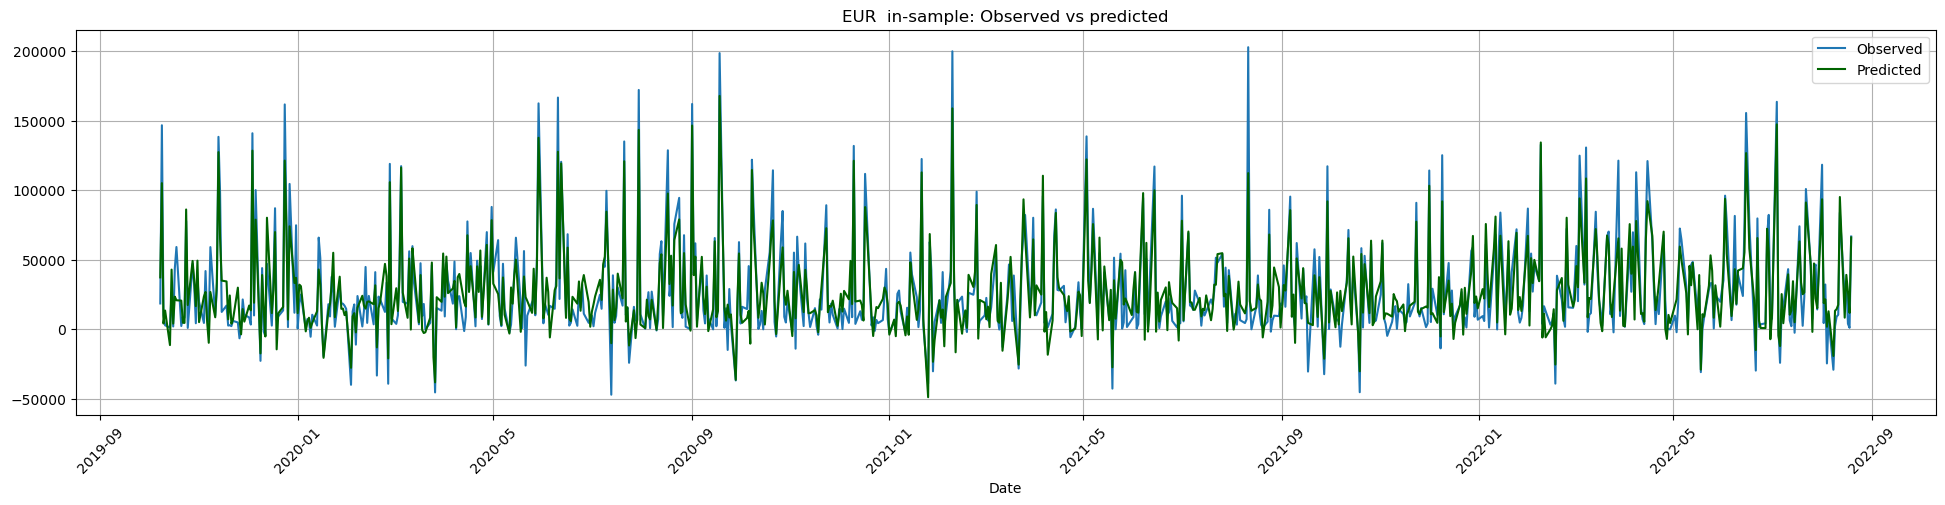

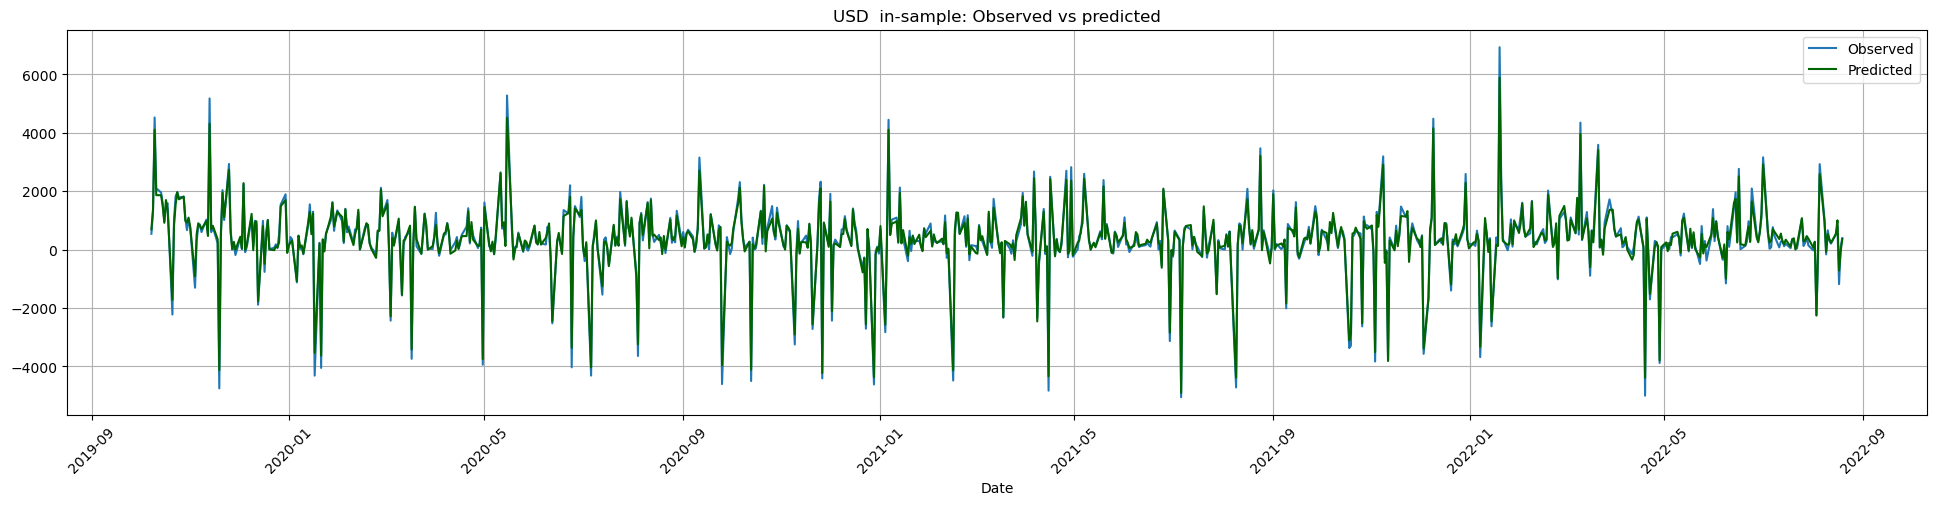

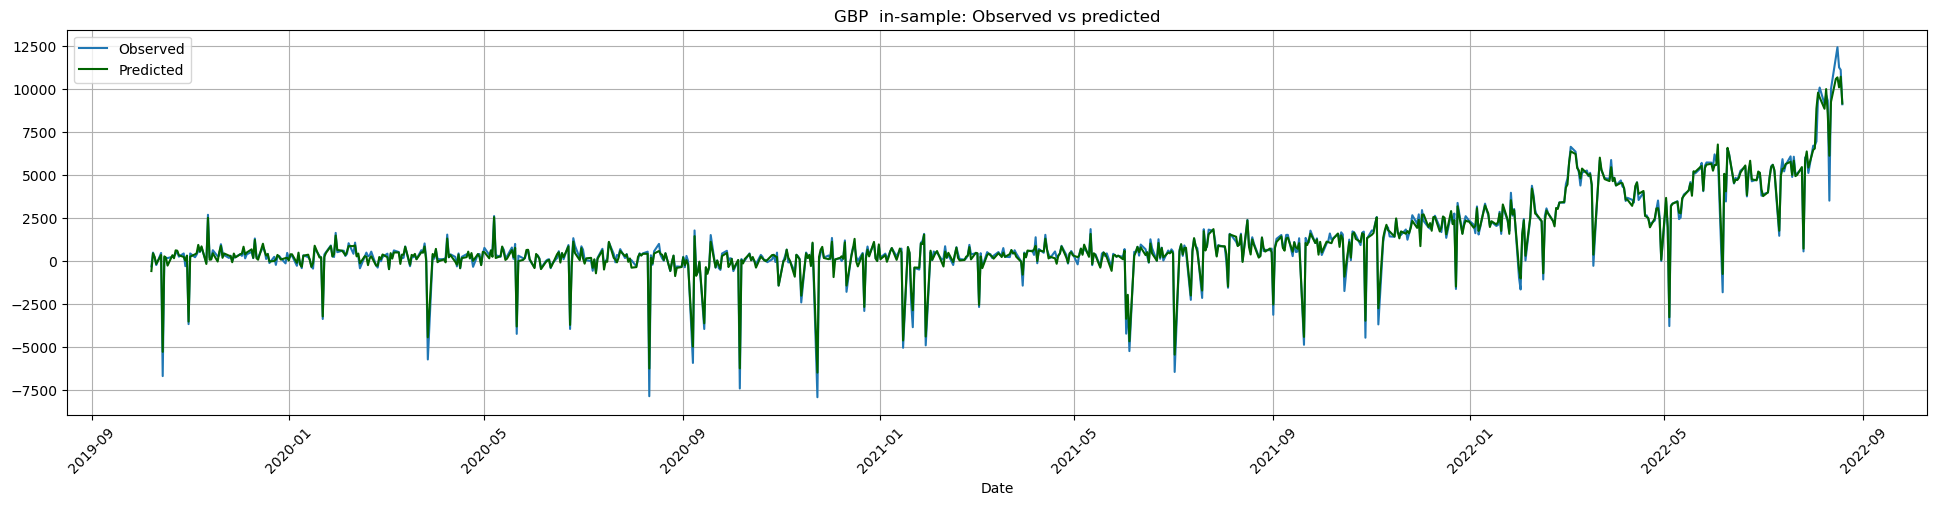

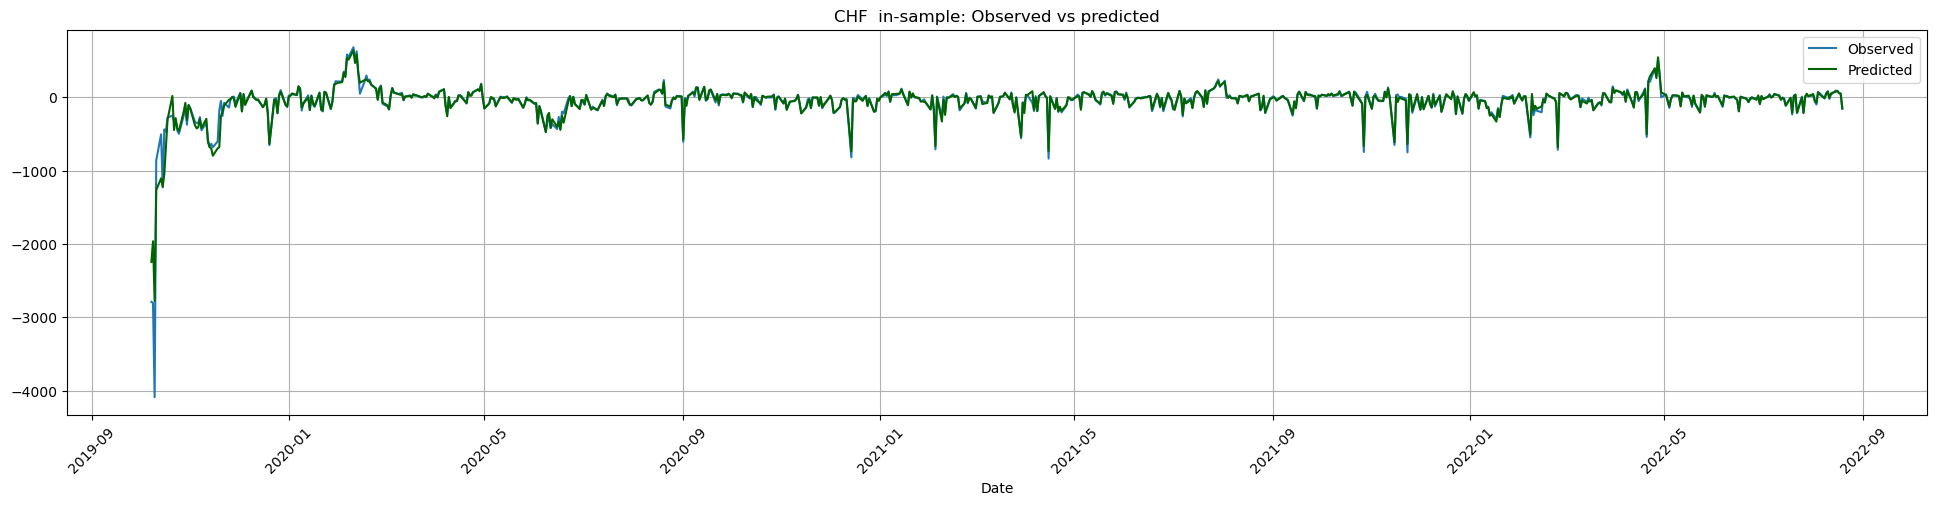

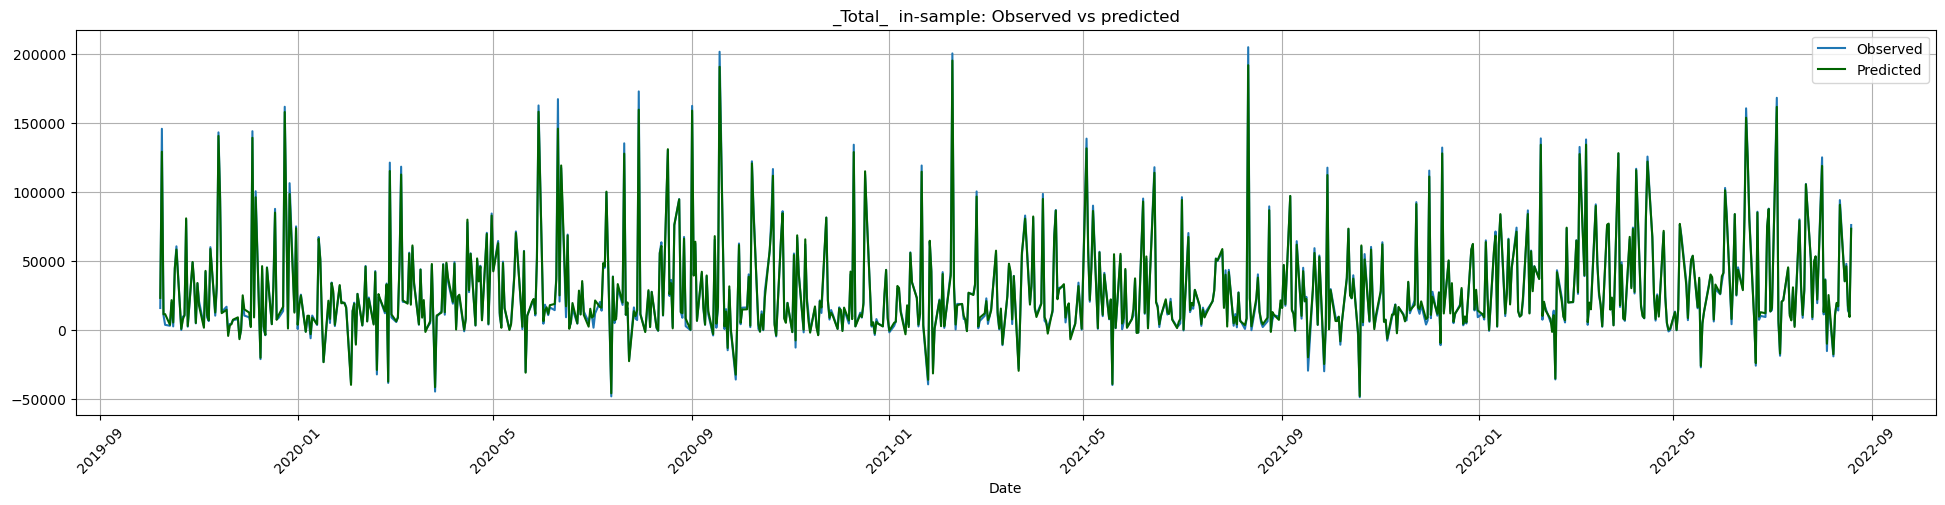

EUR       USD       GBP       CHF  \
Root mean squared error           14,171.3     171.6     289.4      76.9   
Mean absolute error               10,907.2     126.2     176.2      21.4   
Median absolute error              9,287.6      98.0     115.3       8.7   
Total observed Profit         20,647,393.8 269,690.6 878,798.0 -41,430.7   
Total predicted Profit        20,652,066.6 269,690.6 878,798.0 -41,430.7   
Percentage error total Profit          0.0      -0.0       0.0       0.0   
Explained variance                     0.8       1.0       1.0       0.9   
Correlation                            0.9       1.0       1.0       1.0   

                                   _Total_  
Root mean squared error            2,531.4  
Mean absolute error                1,716.1  
Median absolute error              1,253.7  
Total observed Profit         21,754,451.7  
Total predicted Profit        21,754,451.7  
Percentage error total Profit         -0.0  
Explained variance                     1.0  
Correlation                            1.0

In [39]:
# Error Statistics
for c in currencies:
    res_stats_in_gbm = get_error_stats_in(df1_train, gbm_results,  res_stats_in_gbm, x_vars_plus, c = c, PLOT = 1)
res_stats_in_gbm    

#### Out-of-Sample Performance

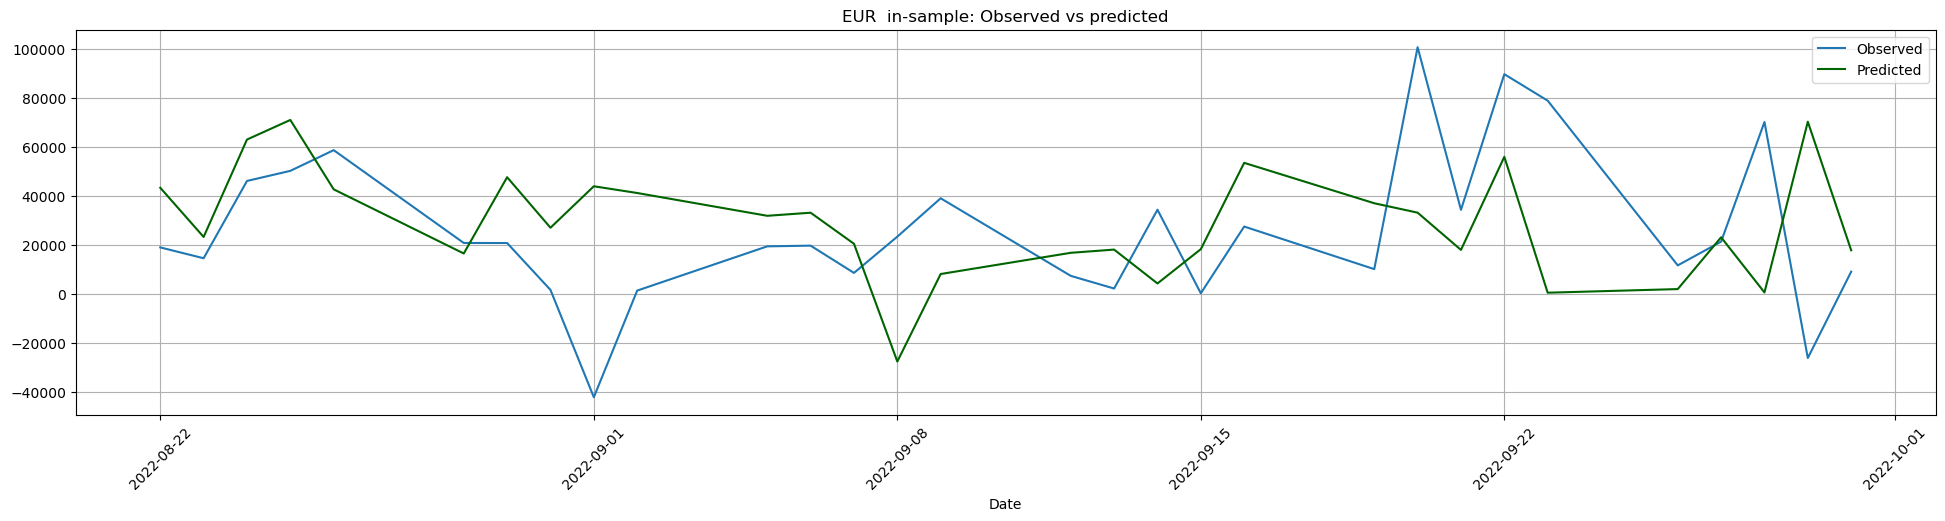

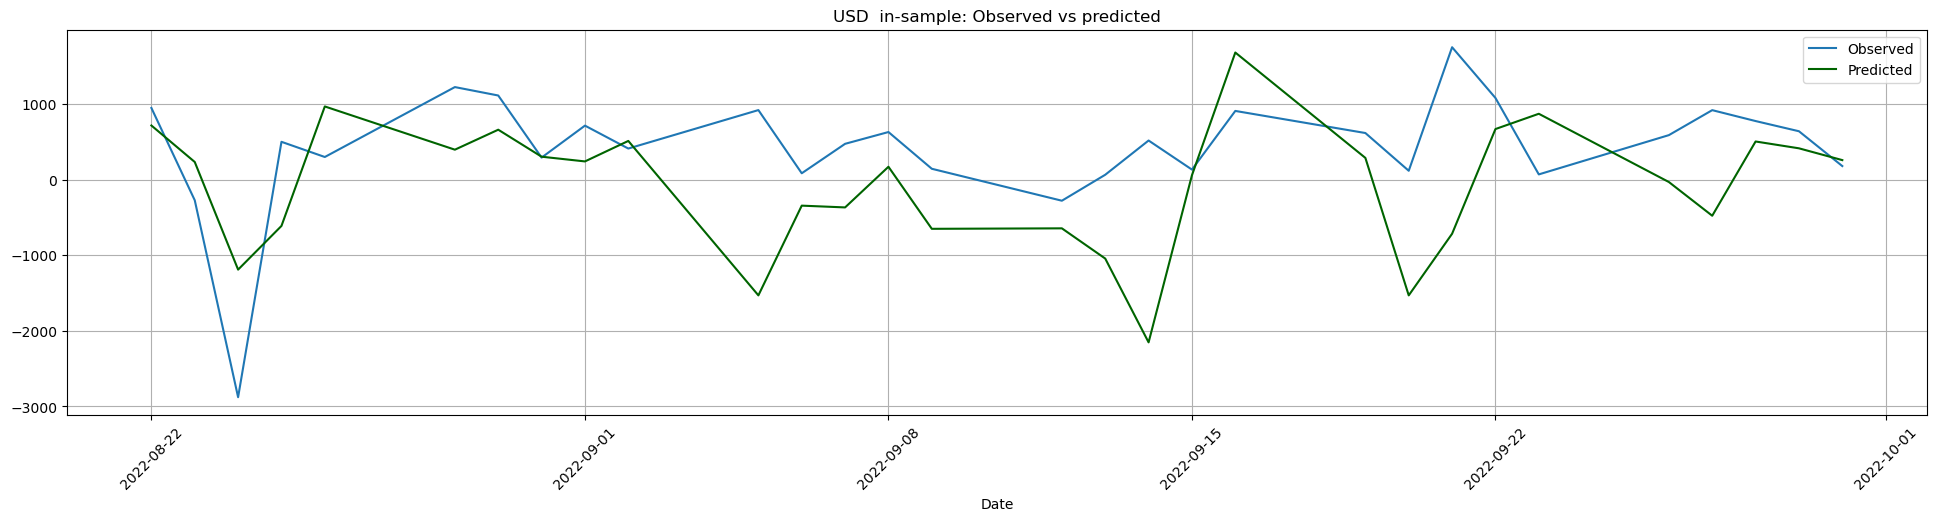

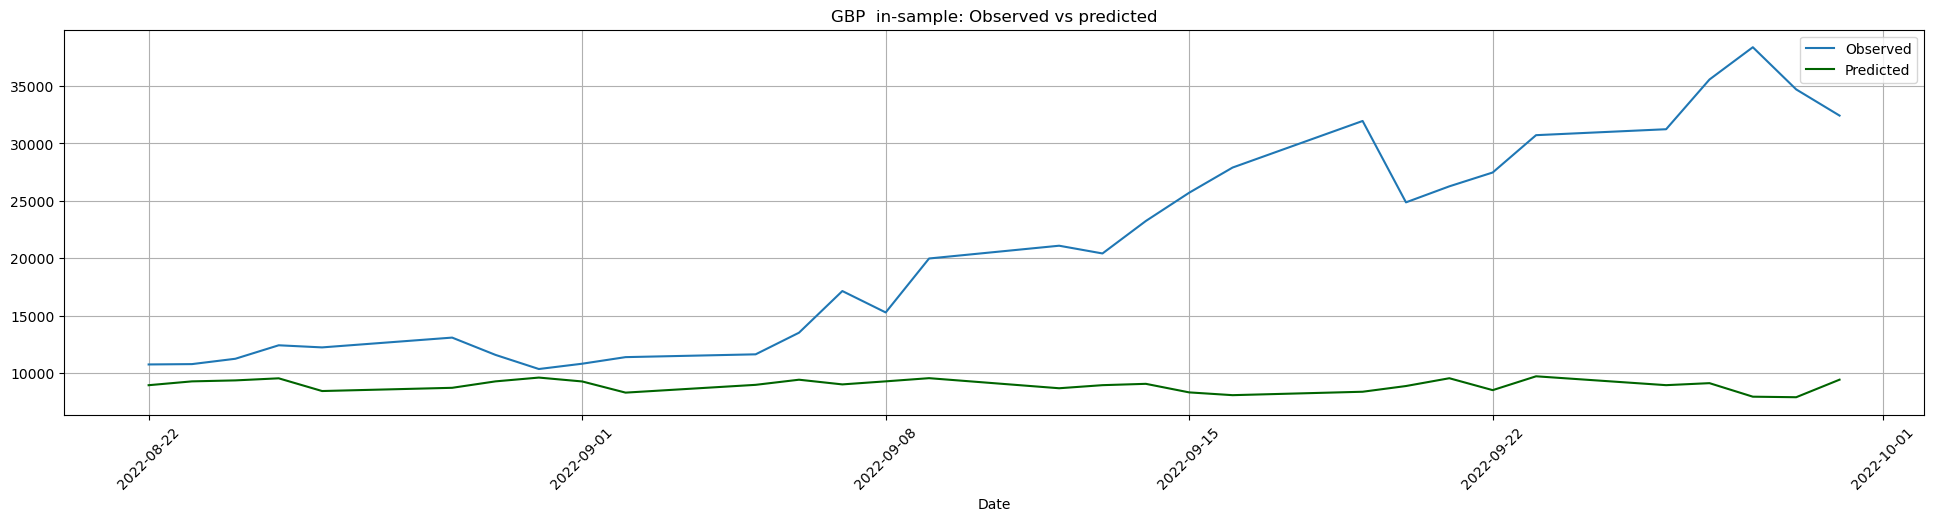

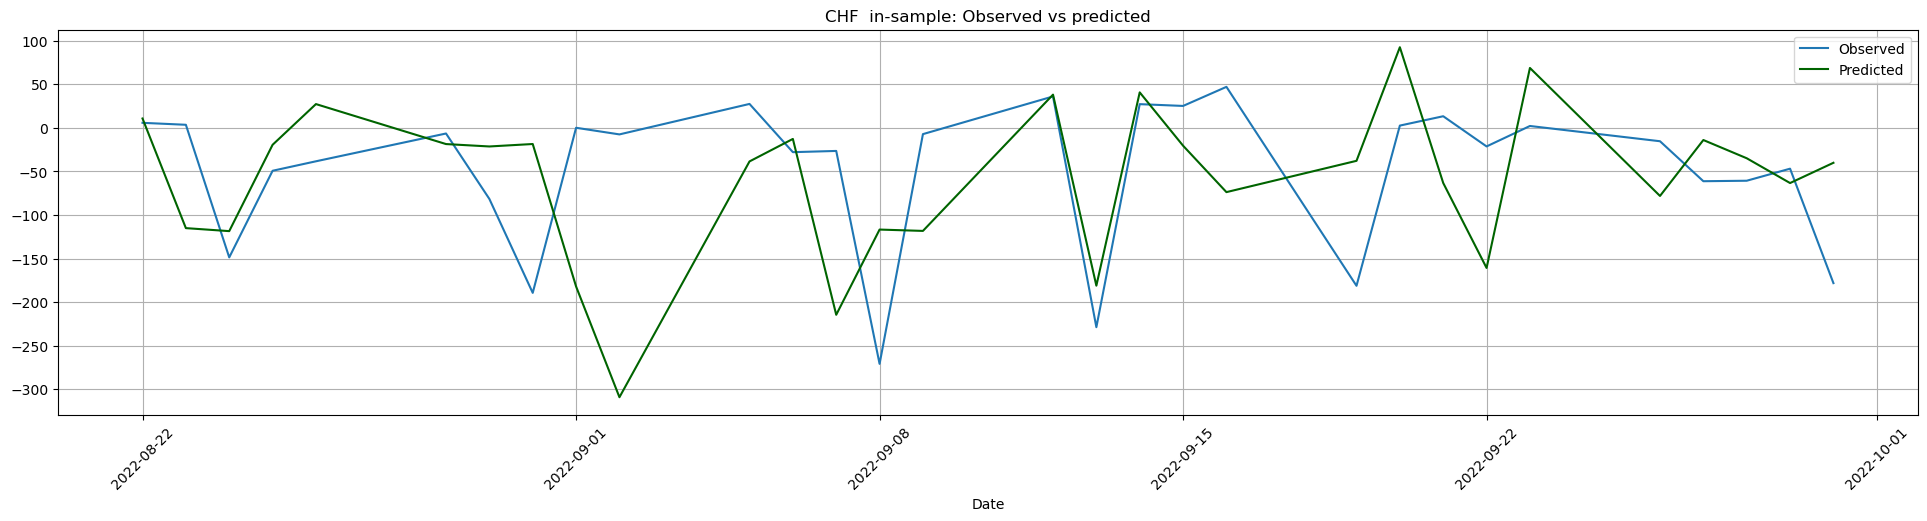

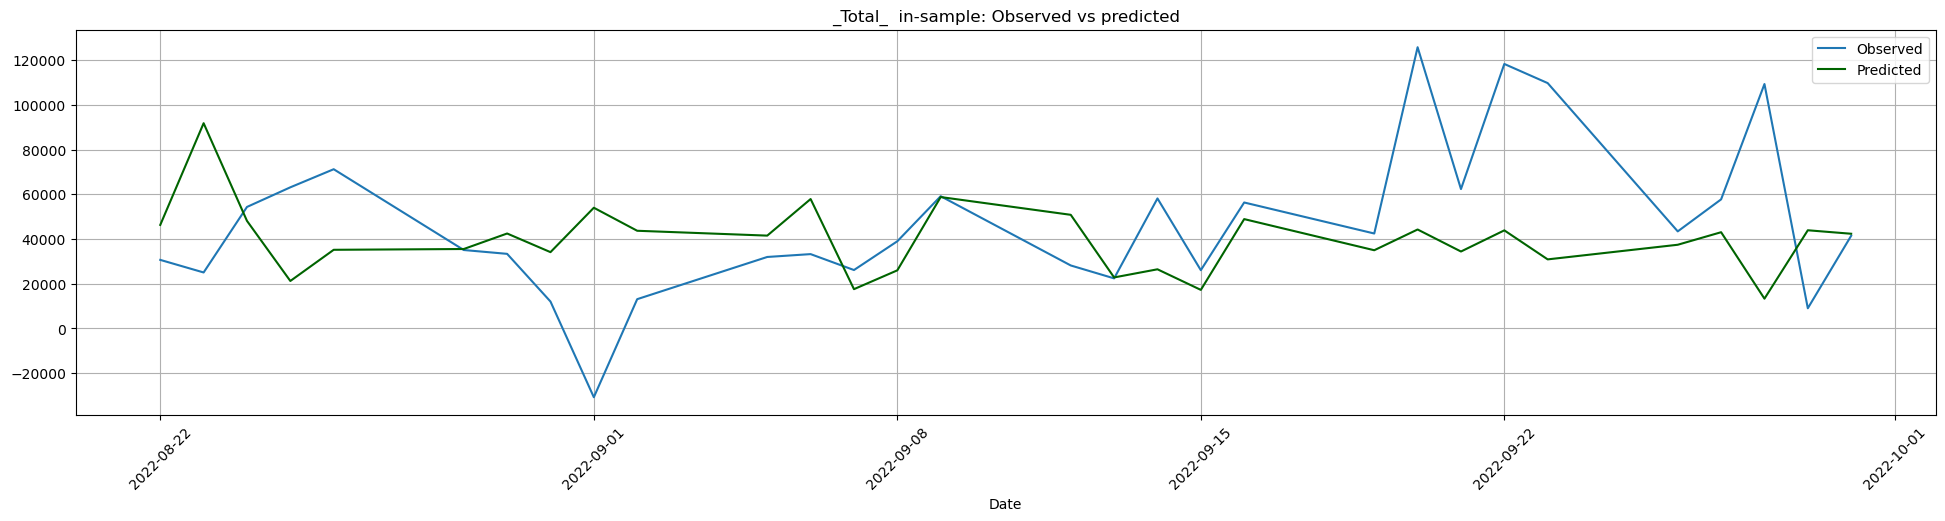

EUR      USD       GBP      CHF  \
Root mean squared error        38,983.8  1,080.5  14,989.2    109.1   
Mean absolute error            29,958.0    810.0  11,851.9     84.9   
Median absolute error          22,598.3    563.6  10,941.1     65.8   
Total observed Profit         771,494.6 12,741.9 624,227.9 -1,456.9   
Total predicted Profit        853,968.5 -2,296.6 268,670.2 -1,792.8   
Percentage error total Profit      10.7   -118.0     -57.0     23.1   
Explained variance                 -0.6     -0.6      -0.0     -0.7   
Correlation                        -0.1      0.3      -0.4      0.2   

                                  _Total_  
Root mean squared error          40,409.7  
Mean absolute error              28,775.4  
Median absolute error            18,860.5  
Total observed Profit         1,407,007.4  
Total predicted Profit        1,188,537.0  
Percentage error total Profit       -15.5  
Explained variance                   -0.4  
Correlation                          -0.2

In [40]:
# Error Statistics
for c in currencies:
    res_stats_out_gbm = get_error_stats_in(df1_test, gbm_results,  res_stats_out_gbm, x_vars_plus, c = c, PLOT = 1)
res_stats_out_gbm    

### Model 3: Long Short-Term Memory Network

The Long Short-Term Memory (LSTM) network is a recurrent neural network.

LSTM networks use memory blocks - instead of neurons - connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence, and each gate within a block uses the sigmoid activation units to control whether it is triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

*    Forget Gate: conditionally decides what information to throw away from the block
*    Input Gate: conditionally decides which values from the input to update the memory state
*    Output Gate: conditionally decides what to output based on input and the memory of the block


In [54]:
# setup 

print(x_vars_plus)

# set the considered currencies
currencies =  ['EUR', 'USD', 'GBP', 'CHF','_Total_']

# initialize results variables 
rnn_results       = dict()
res_stats_in_rnn  = pd.DataFrame()
res_stats_out_rnn = pd.DataFrame()

['y_var_lagged', 'ChangeRequestCosts_lagged', 'AdministrationCosts_lagged', 'OverheadCosts_lagged', 'Interests_lagged', 'Revenue_lagged', 'y_var_lagged2', 'ChangeRequestCosts_lagged2', 'AdministrationCosts_lagged2', 'OverheadCosts_lagged2', 'Interests_lagged2', 'Revenue_lagged2', 'y_var_lagged3', 'ChangeRequestCosts_lagged3', 'AdministrationCosts_lagged3', 'OverheadCosts_lagged3', 'Interests_lagged3', 'Revenue_lagged3', 'y_var_lagged4', 'ChangeRequestCosts_lagged4', 'AdministrationCosts_lagged4', 'OverheadCosts_lagged4', 'Interests_lagged4', 'Revenue_lagged4', 'y_var_lagged5', 'ChangeRequestCosts_lagged5', 'AdministrationCosts_lagged5', 'OverheadCosts_lagged5', 'Interests_lagged5', 'Revenue_lagged5']


In [64]:
# reload functions from utility
reload(sys.modules['utility'])
from utility import *

In [65]:
# get the lstm model(s):
for c in currencies:
    rnn_results[c] = get_lstm(df1_train, df1_test , x_vars_plus, x_vars = x_vars, c = c, PRINT = 1, LOAD = LOAD , output_folder_model = output_folder_model, look_back = look_back)
 


----------------------------------------------------------------------------------------------------
LSTM model for EUR



Input shape: (5, 6)
Output shape: (1, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 4)                 176       
                                                                 
 dense_10 (Dense)            (None, 5)                 25        
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________
None

Start training ...

Epoch 1/100


#### In-Sample Performance

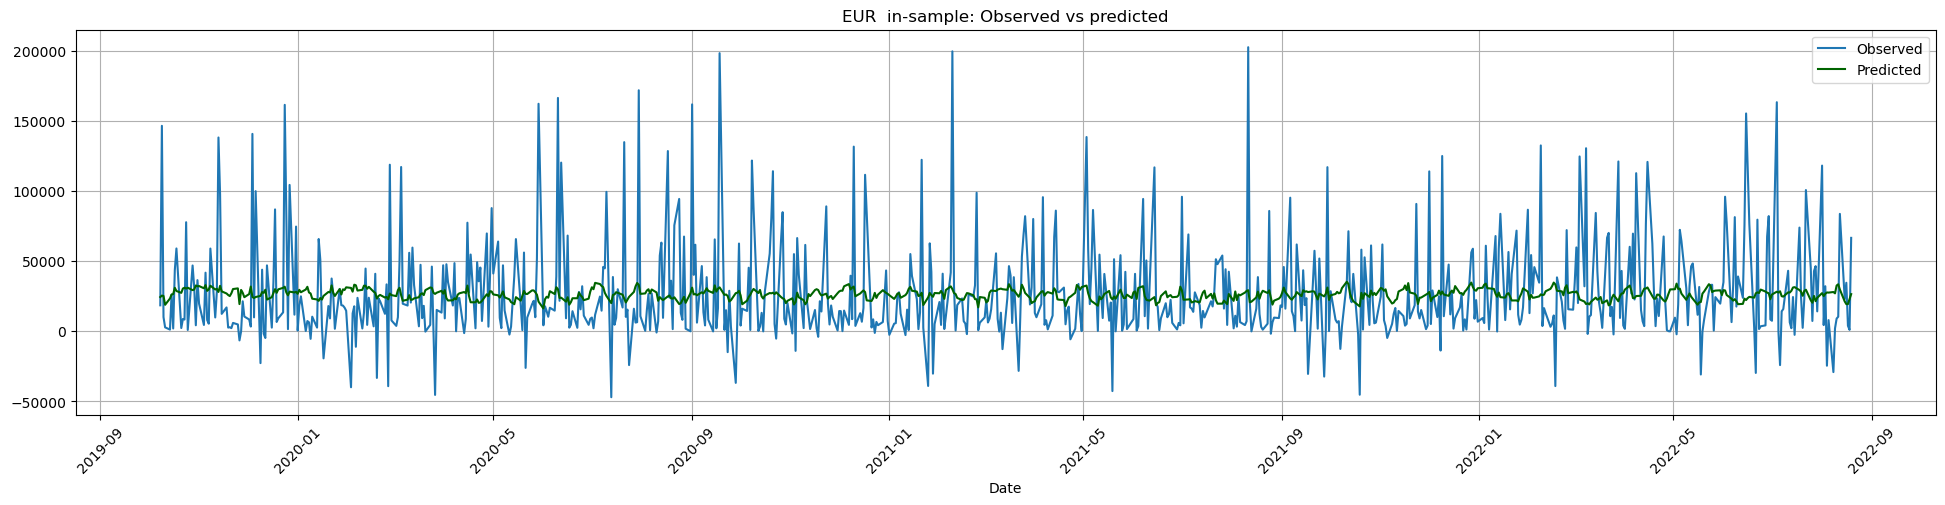

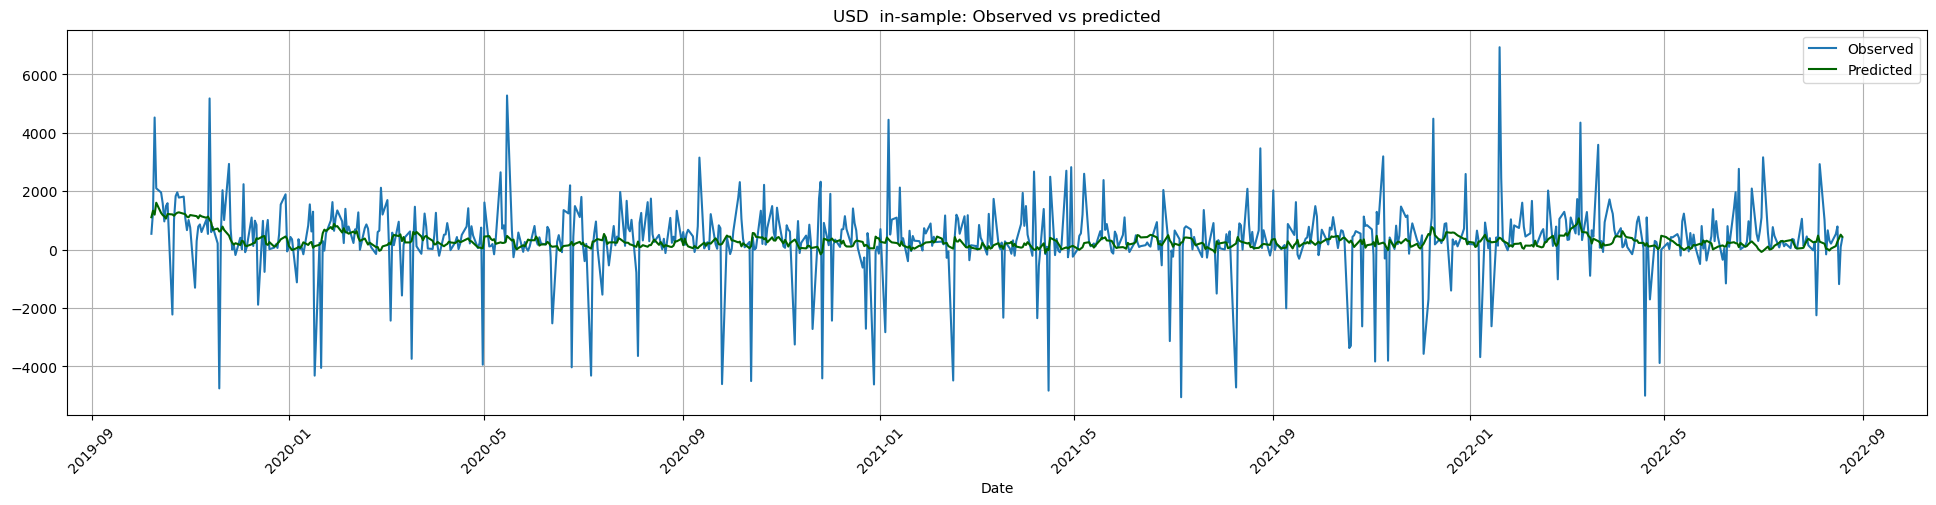

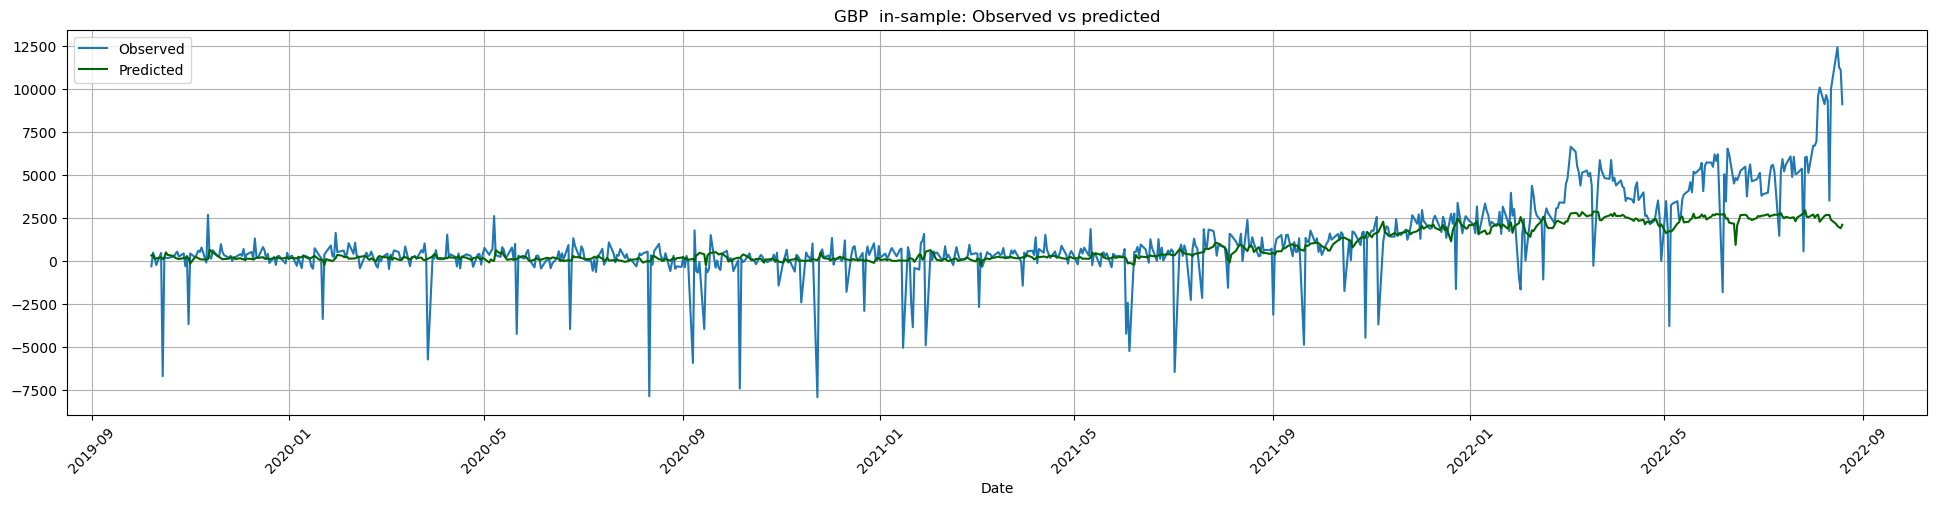

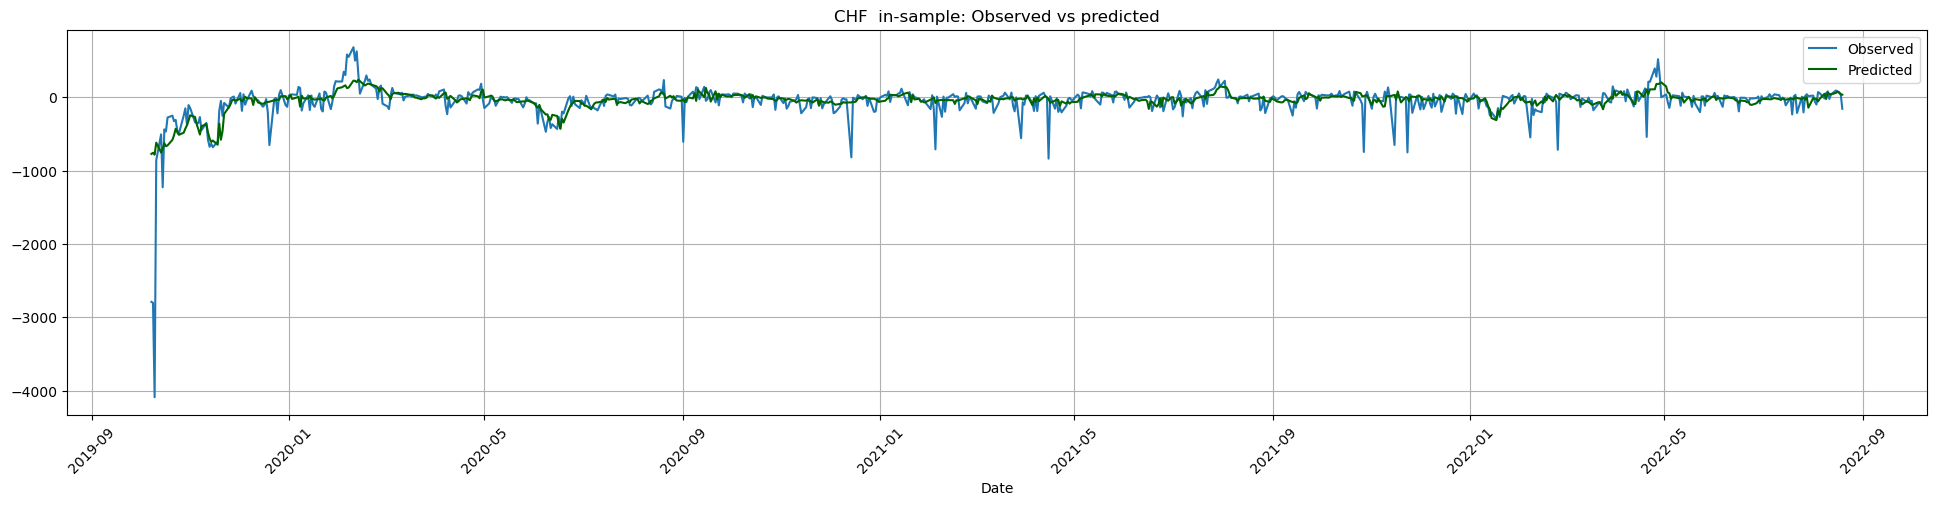

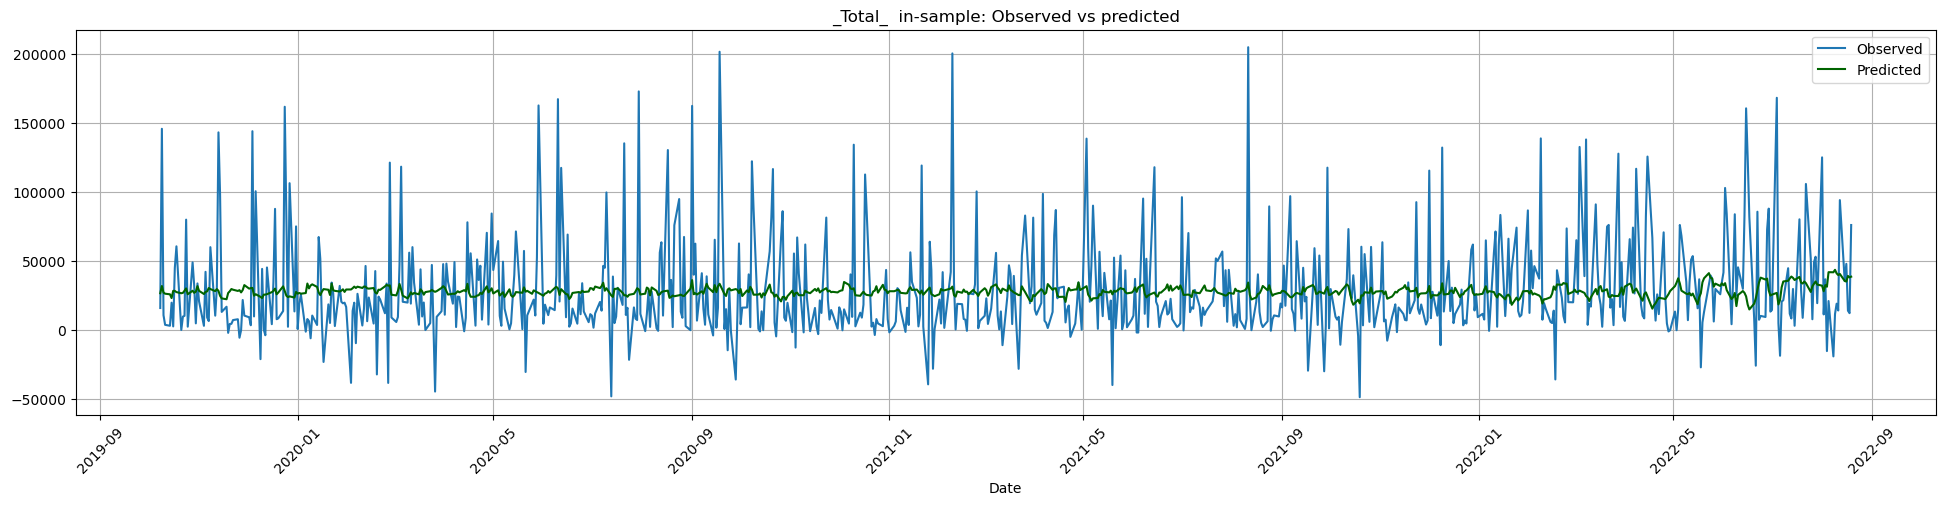

In [ ]:
# plot Actual vs Fitted
for c in currencies:
    plot_observed_vs_predicted(rnn_results[c]['y_train'], rnn_results[c]['trainPredict'], title1 = c+'  in-sample: Observed vs predicted')

In [ ]:
# Error Statistics
for c in currencies:
    res_stats_in_rnn[c] = error_statistics(rnn_results[c]['y_train'], rnn_results[c]['trainPredict'],  colname=c)
res_stats_in_rnn    

EUR       USD       GBP       CHF  \
Root mean squared error           36,042.6   1,222.6   1,780.3     206.7   
Mean absolute error               25,889.4     712.1     978.3      91.6   
Median absolute error             19,935.3     363.1     411.4      54.8   
Total observed Profit         20,647,393.8 269,690.6 878,798.0 -41,430.7   
Total predicted Profit        19,732,387.1 210,481.6 609,484.1 -31,644.7   
Percentage error total Profit         -4.4     -22.0     -30.6     -23.6   
Explained variance                     0.0       0.0       0.4       0.4   
Correlation                            0.1       0.2       0.7       0.6   

                                   _Total_  
Root mean squared error           36,401.1  
Mean absolute error               26,244.8  
Median absolute error             20,223.0  
Total observed Profit         21,754,451.7  
Total predicted Profit        20,996,739.4  
Percentage error total Profit         -3.5  
Explained variance                     0.0  
Correlation                            0.1

#### Forecast: Out-of-sample

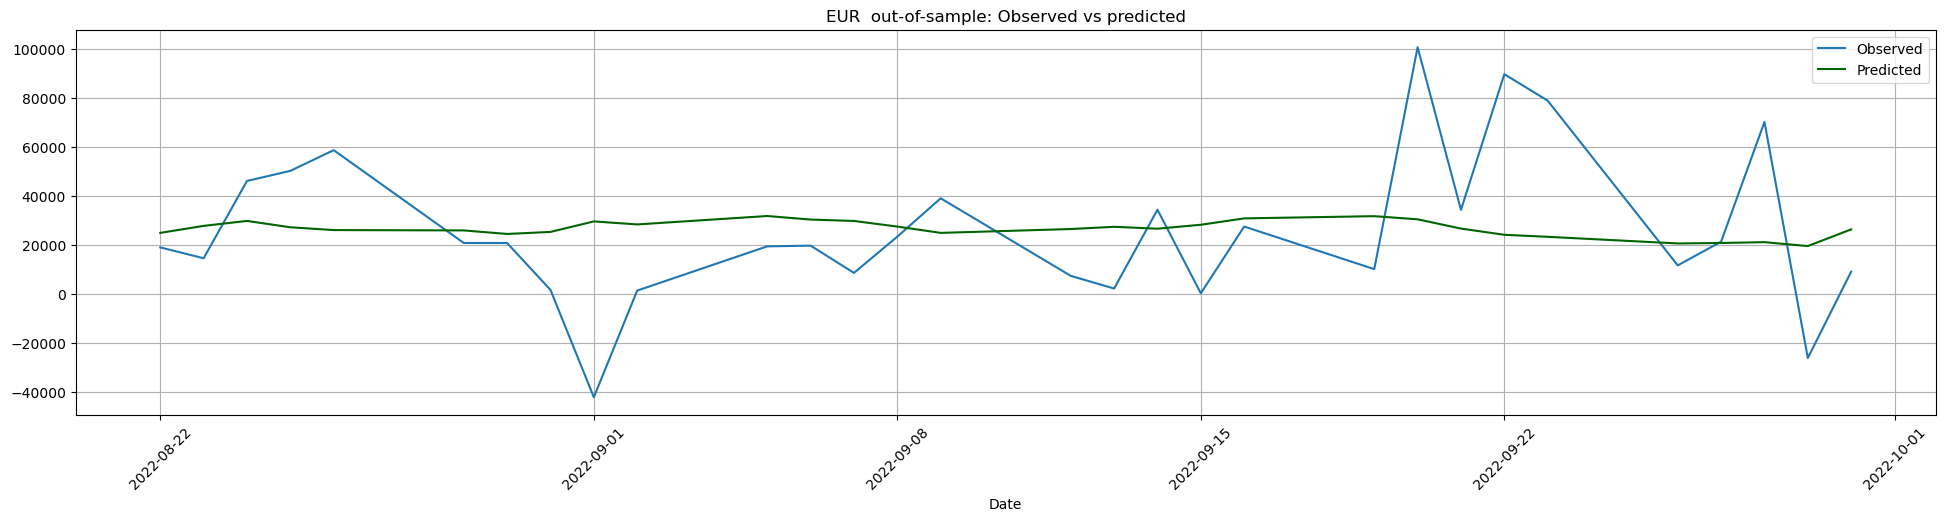

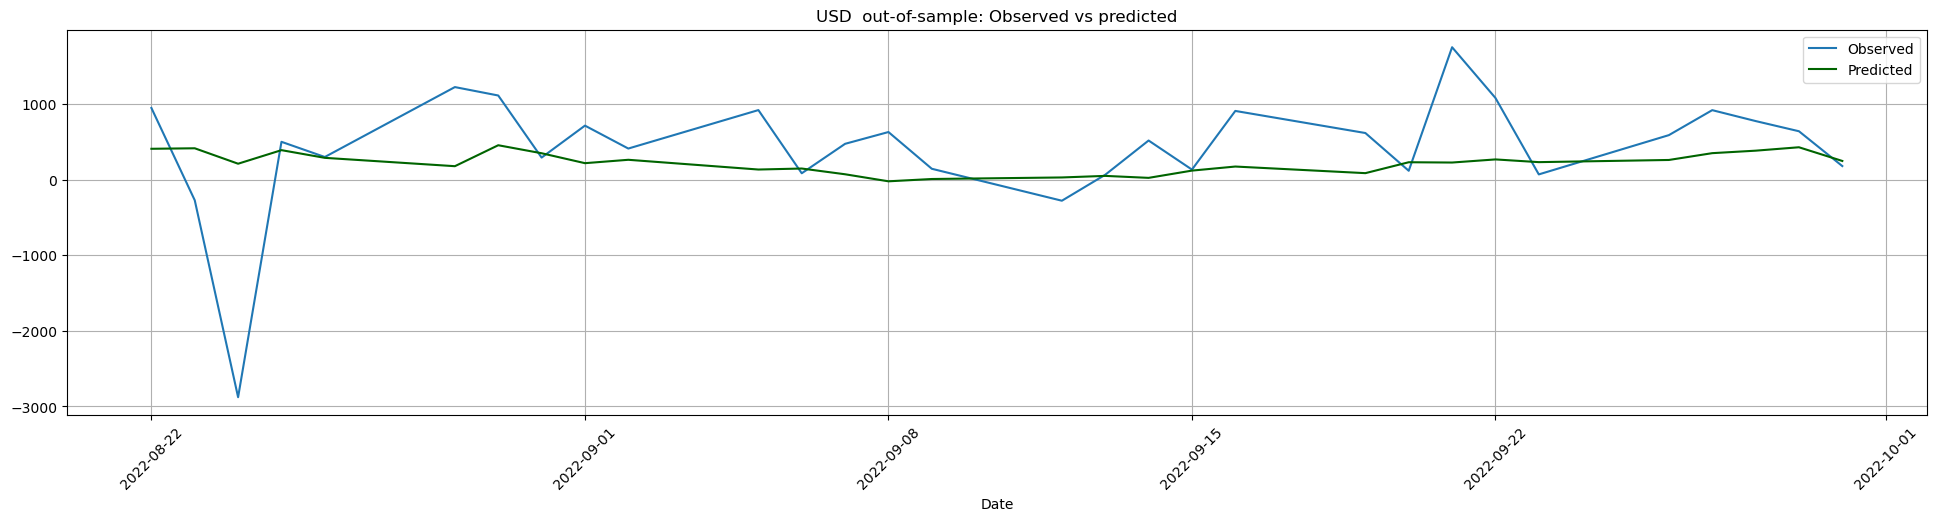

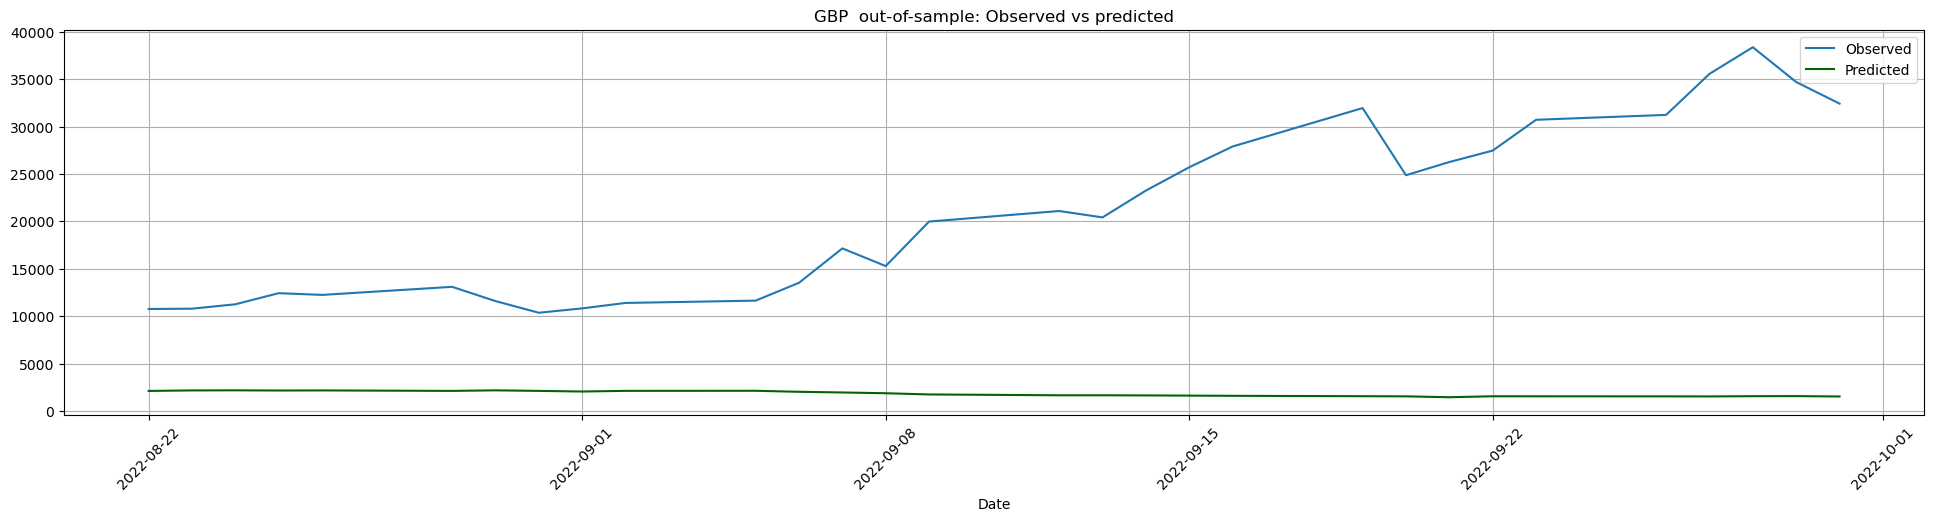

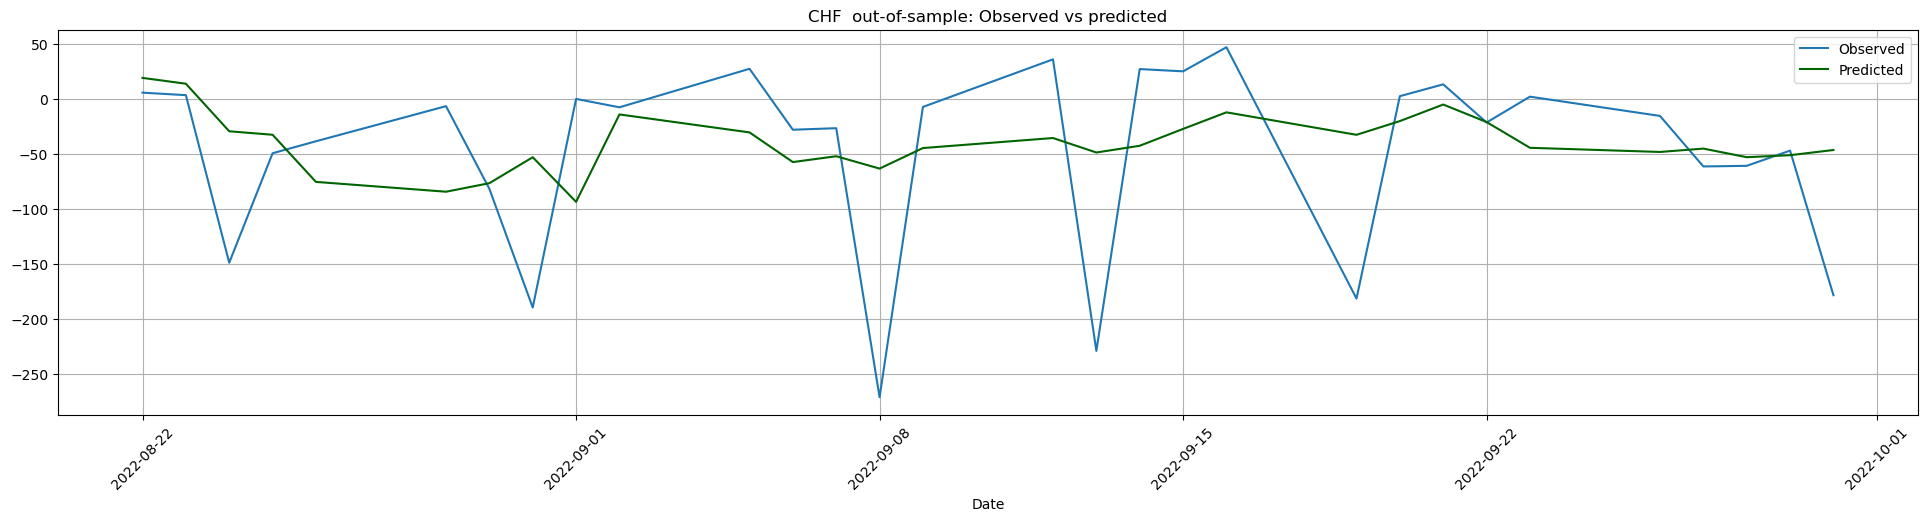

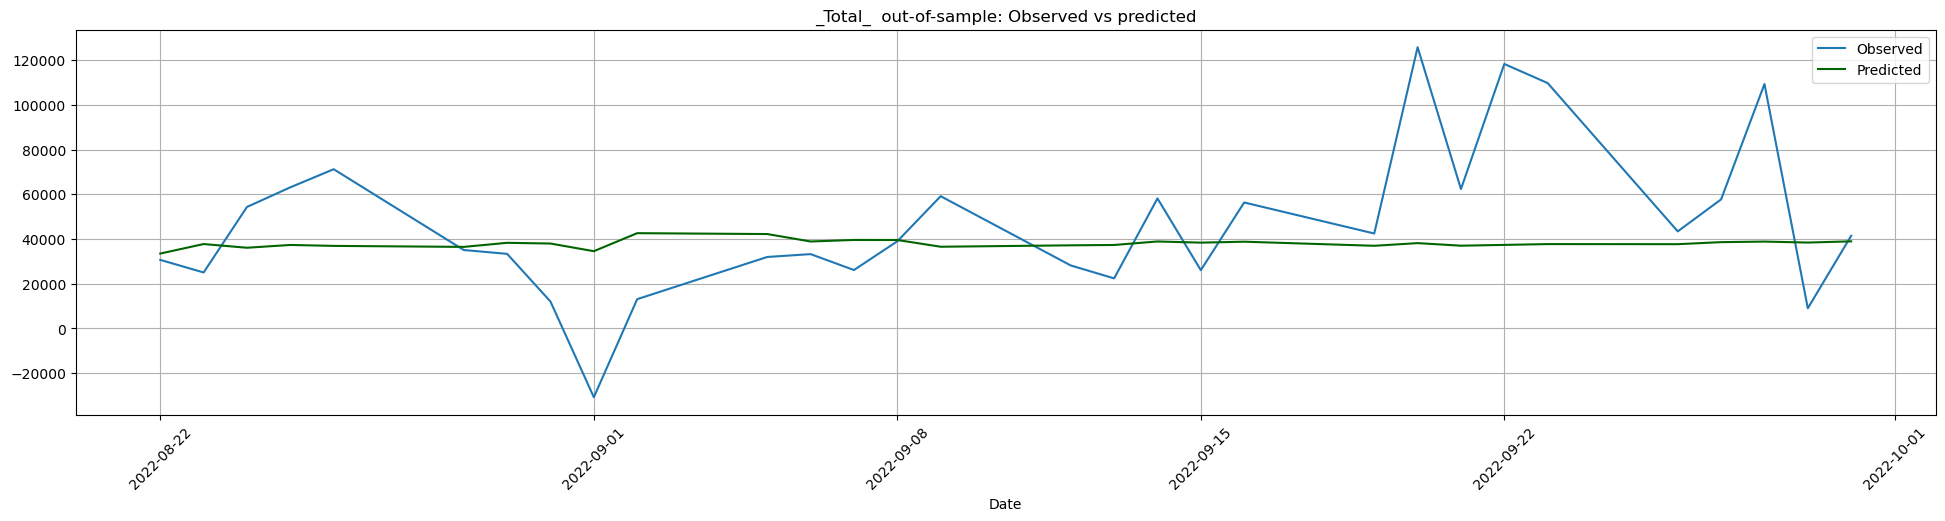

In [ ]:
for c in currencies:
    plot_observed_vs_predicted(rnn_results[c]['y_test'], rnn_results[c]['testPredict'], title1 = c+'  out-of-sample: Observed vs predicted')

In [ ]:
# Error Statistics
for c in currencies:
    res_stats_out_rnn[c] = error_statistics(rnn_results[c]['y_test'], rnn_results[c]['testPredict'], colname=c)
res_stats_out_rnn  


EUR      USD       GBP      CHF  \
Root mean squared error        31,166.9    778.6  21,108.1     79.9   
Mean absolute error            23,713.0    505.7  18,986.9     57.8   
Median absolute error          18,215.5    397.6  18,502.3     37.1   
Total observed Profit         771,494.6 12,741.9 624,227.9 -1,456.9   
Total predicted Profit        796,938.3  6,670.1  54,621.5 -1,203.9   
Percentage error total Profit       3.3    -47.7     -91.2    -17.4   
Explained variance                 -0.0      0.0      -0.1      0.1   
Correlation                        -0.1      0.1      -0.9      0.3   

                                  _Total_  
Root mean squared error          34,858.4  
Mean absolute error              24,834.5  
Median absolute error            17,891.0  
Total observed Profit         1,407,007.4  
Total predicted Profit        1,138,368.7  
Percentage error total Profit       -19.1  
Explained variance                   -0.0  
Correlation                           0.0

### Model Comparison

Train     Test
Model                           
SARIMA EUR     36,189.7 33,846.3
       USD      1,214.1    740.6
       GBP      1,266.6  2,520.2
       CHF        169.9    102.1
       _Total_ 36,304.3 35,567.0
GBM    EUR     14,171.3 38,983.8
       USD        171.6  1,080.5
       GBP        289.4 14,989.2
       CHF         76.9    109.1
       _Total_  2,531.4 40,409.7
LSTM   EUR     36,042.6 31,166.9
       USD      1,222.6    778.6
       GBP      1,780.3 21,108.1
       CHF        206.7     79.9
       _Total_ 36,401.1 34,858.4

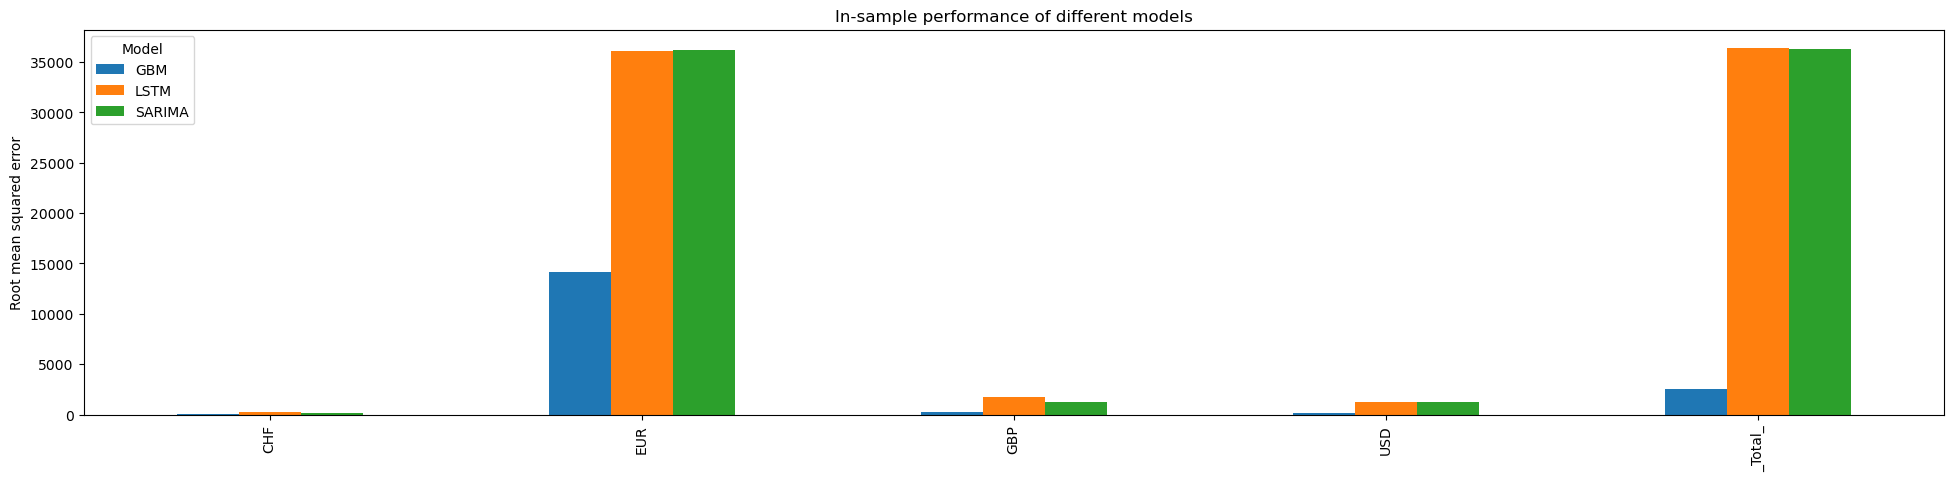

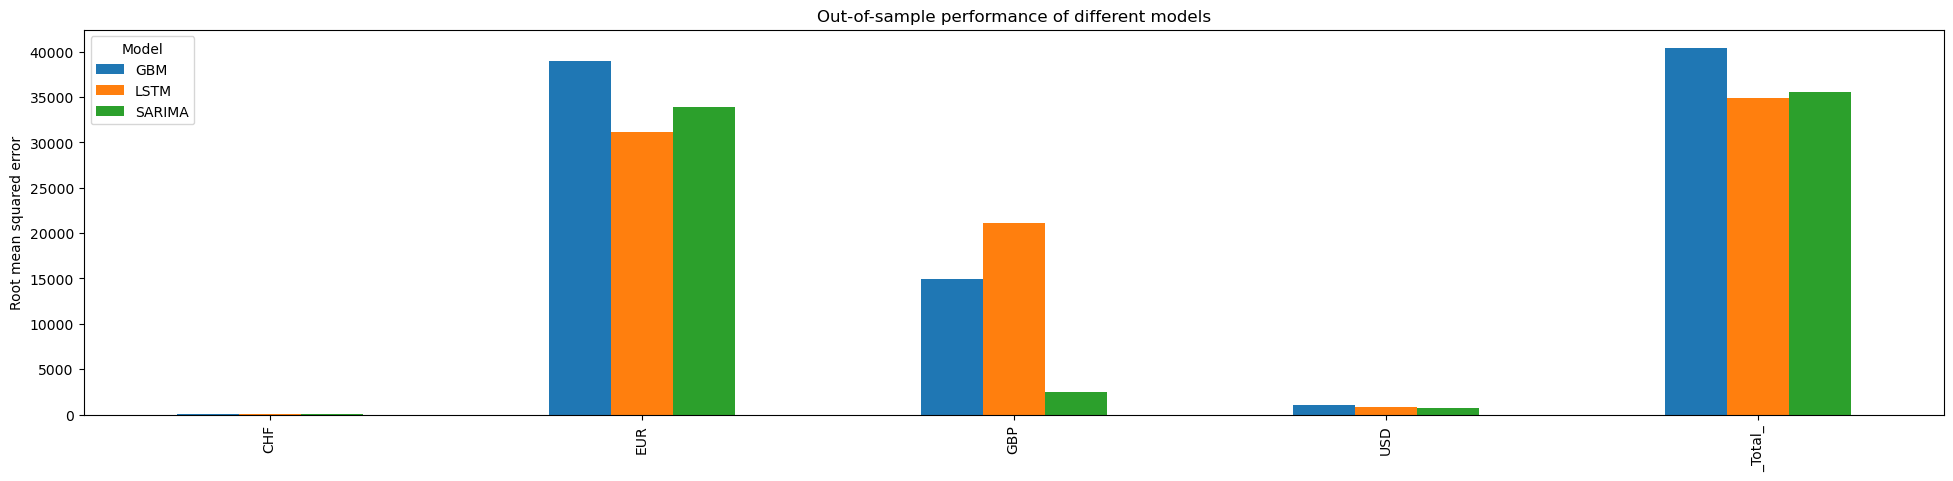

In [ ]:
# get the model comparison:
df_res, df_res_best = get_model_comparison(model_objects_train = (res_stats_in, res_stats_in_gbm, res_stats_in_rnn), model_objects_test = (res_stats_out, res_stats_out_gbm, res_stats_out_rnn))  
df_res

In [ ]:
# best performing model per locale:
df_res_best 

Model          
LSTM    CHF           79.9
        EUR       31,166.9
SARIMA  GBP        2,520.2
        USD          740.6
LSTM    _Total_   34,858.4
Name: Test, dtype: float64

In [ ]:
# reset display settings
if 0:
    pd.reset_option('^display.', silent=True)